
<img src= "https://nooksacktribe.org/wp-content/themes/nooksack-tribe-1-7/dist/assets/images/nooksack-tribe-logo-reverse.png"
style="float:left;width:175px;padding:10px">   
<br />
<br />
# Nooksack Forest Modeling

## Analyze downloaded gridded climate time-series data and generate a hybrid climate product in daily and 3-hourly time series for Velma and DHSVM model inputs

Use this Jupyter Notebook to: <br />
* Map gridded cell centroids,
* Download climate data, <br /> 
* Make dictionaries for watershed data, <br />
* Generate global bias correction factors from low elevations, <br />
* Generate local (1 to 1) bias correction factors for each grid cell, <br />
* Bias correct to monthly means at each grid cell.
* Bias correct to monthly means near observations (low elevations).
* Generate a hydrid climate product dictionary.  <br />
* Map results.  <br />
* Convert daily data to 3-hourly timesteps <br />
* Save data on HydroShare.  <br />
<img src= "https://www.engr.washington.edu/files/mycoe/marcom/cee/imgs/UW_CEE_purp_disp.jpg"
style="float:right;width:350px;padding:10px">  


## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libaries. These are listed in order of a) Python standard libraries, b) hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading and creation, and c) the observatory_gridded_hydromet library that is downloaded with this notebook. 

In [2]:
import os
import pandas as pd, numpy as np, dask, json
from utilities import hydroshare
%matplotlib inline
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")
import copy
import ogh

In [3]:
hs=hydroshare.hydroshare()
homedir = hs.getContentPath('e47aabb406bc45a28f34b97a832daa08')

Successfully established a connection with HydroShare


In [4]:
notebookdir = os.getcwd()

hs=hydroshare.hydroshare()
#homedir = hs.getContentPath(os.environ["HS_RES_ID"])
os.chdir(homedir)
print('Data will be loaded from and save to:'+homedir)

Successfully established a connection with HydroShare
Data will be loaded from and save to:/home/jovyan/work/notebooks/data/e47aabb406bc45a28f34b97a832daa08/e47aabb406bc45a28f34b97a832daa08/data/contents


In [5]:
json.load(open('ogh_meta.json'))

{'dailywrf_salathe2014': {'domain': 'cses.washington.edu/',
  'end_date': '2010-12-31',
  'reference': {'1': 'Salathé Jr EP, Hamlet AF, Mass CF, Lee SY, Stumbaugh M, Steed R. Estimates of twenty-first-century flood risk in the Pacific Northwest based on regional climate model simulations. Journal of Hydrometeorology. 2014 Oct;15(5):1881-99. DOI: 10.1175/JHM-D-13-0137.1',
   '2': 'http://cses.washington.edu/rocinante/WRF/README'},
  'file_format': 'ASCII',
  'spatial_resolution': '1/16-degree',
  'variable_info': {'TMAX': {'units': 'C',
    'dtypes': 'float64',
    'desc': 'Maximum temperature at 2m'},
   'PRECIP': {'units': 'mm',
    'dtypes': 'float64',
    'desc': 'Daily accumulated precipitation'},
   'TMIN': {'units': 'C',
    'dtypes': 'float64',
    'desc': 'Minimum temperature at 2m'},
   'WINDSPD': {'units': 'm/s', 'dtypes': 'float64', 'desc': 'Wind Speed'}},
  'delimiter': '\\s+',
  'decision_steps': '',
  'temporal_resolution': 'D',
  'web_protocol': 'http',
  'subdomain': '/

In [9]:
# initialize ogh_meta
meta_file = dict(ogh.ogh_meta())
sorted(meta_file.keys())


['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014']

In [10]:
# Livneh et al., 2013
dr1 = meta_file['dailymet_livneh2013']

# Salathe et al., 2014
dr2 = meta_file['dailywrf_salathe2014']

# define overlapping time window
dr = ogh.overlappingDates(date_set1=tuple([dr1['start_date'], dr1['end_date']]), 
                          date_set2=tuple([dr2['start_date'], dr2['end_date']]))
dr

('1950-01-01', '2010-12-31')

If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to return to the File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## 2. Get list of gridded climate points for the watershed

This example uses a shapefile with the watershed boundary of the SKookum Basin, which is stored in HydroShare at the following url: https://www.hydroshare.org/resource/23fcce3c57584468b06526285f1116f5/. 

The data for our processing routines can be retrieved using the getResourceFromHydroShare function by passing in the global identifier from the url above.  In the next cell, we download this resource from HydroShare, and identify that the points in this resource are available for downloading gridded hydrometeorology data, based on the point shapefile at https://www.hydroshare.org/resource/ef2d82bf960144b4bfb1bae6242bcc7f/, which is for the extent of North America and includes the average elevation for each 1/16 degree grid cell.  The file must include columns with station numbers, latitude, longitude, and elevation. The header of these columns must be FID, LAT, LONG_, and ELEV or RASTERVALU, respectively. The station numbers will be used for the remainder of the code to uniquely reference data from each climate station, as well as to identify minimum, maximum, and average elevation of all of the climate stations.  The webserice is currently set to a URL for the smallest geographic overlapping extent - e.g. WRF for Columbia River Basin (to use a limit using data from a FTP service, treatgeoself() would need to be edited in observatory_gridded_hydrometeorology utility). 

In [15]:
""""
1/16-degree Gridded cell centroids
"""
# List of available data
hs.getResourceFromHydroShare('ef2d82bf960144b4bfb1bae6242bcc7f')
NAmer = hs.content['NAmer_dem_list.shp']

"""
Skookum (South Fork Nooksack)
"""
# Watershed extent
hs.getResourceFromHydroShare('ef2d82bf960144b4bfb1bae6242bcc7f')
skookum = hs.content['SkookumHUC171100040404.shp']


This resource already exists in your userspace.
ef2d82bf960144b4bfb1bae6242bcc7f/
|-- ef2d82bf960144b4bfb1bae6242bcc7f/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- NAmer_dem_list.cpg
|   |   |   |-- NAmer_dem_list.dbf
|   |   |   |-- NAmer_dem_list.prj
|   |   |   |-- NAmer_dem_list.sbn
|   |   |   |-- NAmer_dem_list.sbx
|   |   |   |-- NAmer_dem_list.shp
|   |   |   |-- NAmer_dem_list.shx
|   |   |   |-- NooksackHUC17110004.cpg
|   |   |   |-- NooksackHUC17110004.shp
|   |   |   |-- NooksackHUC17110004.shx
|   |   |   |-- SouthForkHUC1711000404.shp
|   |   |   |-- SouthForkHUC1711000404.shx
|   |   |   |-- NooksackHUC17110004.dbf
|   |   |   |-- NooksackHUC17110004.prj
|   |   |   |-- Observatory_nooksack_hybridbiascorrection_20190926.ipynb
|   |   |   |-- Observatory_skagit_hybridbiascorrection_20190315.ipynb
|   |   |   |-- OG

This resource already exists in your userspace.
ef2d82bf960144b4bfb1bae6242bcc7f/
|-- ef2d82bf960144b4bfb1bae6242bcc7f/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- NAmer_dem_list.cpg
|   |   |   |-- NAmer_dem_list.dbf
|   |   |   |-- NAmer_dem_list.prj
|   |   |   |-- NAmer_dem_list.sbn
|   |   |   |-- NAmer_dem_list.sbx
|   |   |   |-- NAmer_dem_list.shp
|   |   |   |-- NAmer_dem_list.shx
|   |   |   |-- NooksackHUC17110004.cpg
|   |   |   |-- NooksackHUC17110004.shp
|   |   |   |-- NooksackHUC17110004.shx
|   |   |   |-- SouthForkHUC1711000404.shp
|   |   |   |-- SouthForkHUC1711000404.shx
|   |   |   |-- NooksackHUC17110004.dbf
|   |   |   |-- NooksackHUC17110004.prj
|   |   |   |-- Observatory_nooksack_hybridbiascorrection_20190926.ipynb
|   |   |   |-- Observatory_skagit_hybridbiascorrection_20190315.ipynb
|   |   |   |-- OG

KeyboardInterrupt: 

In [59]:
# Generate list of stations to download
mappingfile1=ogh.treatgeoself(shapefile=skookum, NAmer=NAmer, buffer_distance=0.09, 
                              mappingfile=os.path.join(os.getcwd(),'skookum_mappingfile.csv'))
print(mappingfile1)


(20, 4)
   FID       LAT      LONG_    ELEV
0    0  48.78125 -121.96875  1029.0
1    1  48.78125 -122.03125   740.0
2    2  48.78125 -122.09375   526.0
3    3  48.78125 -122.15625   403.0
4    4  48.71875 -121.90625  1061.0
/home/jovyan/work/notebooks/data/e47aabb406bc45a28f34b97a832daa08/e47aabb406bc45a28f34b97a832daa08/data/contents/skookum_mappingfile.csv


## Map the Gridded Cell Centroids that intersect with the watersheds of interest
### Summarize the file availability from each watershed mapping file

 ## 2. Download climate data 

In [81]:
ogh.getDailyMET_livneh2013(homedir, mappingfile1)
ogh.getDailyWRF_salathe2014(homedir, mappingfile1)

Meteorology_Livneh_CONUSExt_v.1.2_2013_48.78125_-122.09375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.78125_-122.03125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.78125_-122.15625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.78125_-121.96875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.71875_-121.90625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.71875_-121.96875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.71875_-122.03125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.71875_-122.09375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.71875_-122.15625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.71875_-122.21875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.65625_-121.90625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.65625_-121.96875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.65625_-122.03125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.65625_-122.09375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.65625_

'/home/jovyan/work/notebooks/data/e47aabb406bc45a28f34b97a832daa08/e47aabb406bc45a28f34b97a832daa08/data/contents/salathe2014/WWA_1950_2010/raw'

## 3. Put data in dictionaries by watershed


In [82]:
ltm_skook = ogh.gridclim_dict(mappingfile=mappingfile1,
                               metadata=meta_file,
                               dataset='dailymet_livneh2013',
                               file_start_date=dr1['start_date'], 
                               file_end_date=dr1['end_date'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1])

ltm_skook = ogh.gridclim_dict(mappingfile=mappingfile1,
                               metadata=meta_file,
                               dataset='dailywrf_salathe2014',
                               file_start_date=dr2['start_date'], 
                               file_end_date=dr2['end_date'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1],
                               df_dict=ltm_skook)

   FID       LAT      LONG_    ELEV  \
0    0  48.78125 -121.96875  1029.0   
1    1  48.78125 -122.03125   740.0   
2    2  48.78125 -122.09375   526.0   
3    3  48.78125 -122.15625   403.0   
4    4  48.71875 -121.90625  1061.0   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                                dailywrf_salathe2014  
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
Number of gridded data files:20
Minimum elevation: 302.0m
Mean elevation: 709.95m
Maximum elevatio

## 4. Local: 
### Generate dataframe of correction factors for each i,j grid cell

In [83]:
BiasCorr_wrfbc_skook = ogh.compute_diffs(df_dict=ltm_skook, df_str='skookum',
                                   gridclimname1='dailywrf_salathe2014',
                                   gridclimname2='dailymet_livneh2013',
                                   prefix2=['month'],
                                   prefix1=meta_file['dailymet_livneh2013']['variable_list'])

BiasCorr_wrfbc_skook_P = ogh.compute_ratios(df_dict=ltm_skook, df_str='skookum',
                                      gridclimname1='dailywrf_salathe2014',
                                      gridclimname2='dailymet_livneh2013',
                                      prefix2=['month'],
                                      prefix1=meta_file['dailymet_livneh2013']['variable_list'])

           
BiasCorr_wrfbc_skook['PRECIP_skook'] = BiasCorr_wrfbc_skook_P['PRECIP_skookum']
ogh.saveDictOfDf('BiasCorr_wrfbc_skookum.json', dictionaryObject=BiasCorr_wrfbc_skook)
BiasCorrTemplate=BiasCorr_wrfbc_skook #size of input grid cells

In [84]:

print(BiasCorr_wrfbc_skook)

print('WRF')
print(ltm_skook['month_PRECIP_dailywrf_salathe2014'][200])
print('Obs')
print(ltm_skook['month_PRECIP_dailymet_livneh2013'][200])
print('LivBCWRF = Local Correction Factor')
print(BiasCorr_wrfbc_skook['PRECIP_skook'][200])
print(BiasCorr_wrfbc_skook)

{'PRECIP_skookum':            0          1          2          3          4          5   \
     48.78125   48.78125   48.78125   48.78125   48.71875   48.71875   
   -121.96875 -122.03125 -122.09375 -122.15625 -121.90625 -121.96875   
1    5.799870   3.472570   1.494860   1.750653   4.605063   2.415227   
2    5.425682   3.589948   2.208221   2.006686   5.173546   2.870876   
3    5.468699   3.950093   2.432417   2.089804   5.233485   3.853617   
4    4.494713   3.729464   2.835732   2.229459   4.858511   4.203770   
5    2.314334   2.871071   2.510418   1.833778   1.492263   1.917351   
6    2.604590   2.406533   1.887795   1.519975   2.304822   2.126751   
7    1.405116   1.109297   0.846420   0.512840   0.653392   0.861029   
8    0.741185   0.518117   0.353265   0.240344   0.756211   0.662292   
9    0.919552   0.438363   0.056172   0.094383   1.080331   0.381893   
10   2.021549   0.623715  -0.317787   0.319807   1.815090  -0.279426   
11   7.019260   4.805883   2.666492   1.94913

KeyError: 200

In [85]:
ltm_skook['month_PRECIP_dailywrf_salathe2014']

0          1          2          3          4          5   \
     48.78125   48.78125   48.78125   48.78125   48.71875   48.71875   
   -121.96875 -122.03125 -122.09375 -122.15625 -121.90625 -121.96875   
1   16.246235  14.584733  12.487668  10.388926  17.997382  16.582480   
2   13.491062  12.064846  10.334875   8.605264  15.009327  13.782948   
3   11.649133  10.427525   9.006425   7.586922  13.107546  12.067419   
4    8.666093   8.076760   7.179475   6.281399   9.460874   9.051038   
5    5.989942   5.847393   5.171973   4.499154   6.089513   6.158493   
6    5.477842   5.464415   4.844530   4.225918   5.279699   5.507202   
7    2.818112   2.723205   2.410434   2.098879   2.797324   2.791819   
8    2.939492   2.779540   2.493363   2.207187   3.109714   3.030973   
9    4.751792   4.448322   3.990721   3.532361   5.286464   5.070514   
10  10.144897   9.242819   8.134632   7.026616  11.376684  10.636319   
11  15.690995  14.137891  12.196027  10.255005  17.488350  16.230306   
12  16.126103  14.433453  12.352216  10.271597  17.858630  16.432623   

           6          7          8          9          10         11  \
     48.71875   48.71875   48.71875   48.71875   48.65625   48.65625   
   -122.03125 -122.09375 -122.15625 -122.21875 -121.90625 -121.96875   
1   14.929540  13.215727  11.136007   9.662200  16.794553  15.835939   
2   12.348178  10.937052   9.222281   7.986071  13.829286  13.068015   
3   10.833072   9.676832   8.269609   7.195098  12.088567  11.532871   
4    8.423262   7.615541   6.724863   5.923792   8.958530   8.850448   
5    6.014590   5.393585   4.721898   4.099577   6.090957   6.183675   
6    5.555361   5.031918   4.414104   3.832153   5.506546   5.602109   
7    2.728139   2.470333   2.157620   1.855494   2.827054   2.783083   
8    2.878757   2.602041   2.315817   2.022237   3.025669   3.014077   
9    4.744836   4.285945   3.831000   3.390574   5.228541   5.133607   
10   9.720925   8.778329   7.681185   6.801036  10.781761  10.389434   
11  14.705355  13.166863  11.241776   9.812344  16.312104  15.609880   
12  14.774395  13.144675  11.081148   9.630592  16.496568  15.590100   

           12         13         14         15         16         17  \
     48.65625   48.65625   48.65625   48.65625   48.59375   48.59375   
   -122.03125 -122.09375 -122.15625 -122.21875 -121.96875 -122.03125   
1   14.786621  13.079614  11.373882  10.093120  13.319762  12.515357   
2   12.227191  10.821248   9.416692   8.342345  10.896332  10.264608   
3   10.889328   9.740238   8.592628   7.657229   9.761359   9.285680   
4    8.585470   7.783011   6.981344   6.239940   7.696858   7.532973   
5    6.096341   5.478096   4.860185   4.274135   5.383813   5.366806   
6    5.544514   5.023000   4.499120   3.973760   4.821749   4.824574   
7    2.692940   2.433934   2.176002   1.902771   2.425124   2.361613   
8    2.941322   2.665944   2.391518   2.113363   2.643829   2.602115   
9    4.963175   4.507055   4.052311   3.628617   4.479421   4.370169   
10   9.916446   8.978942   8.044426   7.264019   8.830217   8.507483   
11  14.785333  13.255738  11.726896  10.503945  13.235978  12.641448   
12  14.602290  12.978641  11.356700  10.128757  13.112771  12.364178   

           18         19  
     48.59375   48.59375  
   -122.09375 -122.15625  
1   12.012977  10.637097  
2    9.883030   8.759304  
3    8.962374   8.041306  
4    7.259607   6.603880  
5    5.134373   4.620783  
6    4.648951   4.222525  
7    2.256965   2.040973  
8    2.493585   2.265241  
9    4.229519   3.861508  
10   8.320243   7.590264  
11  12.255530  11.041077  
12  11.922819  10.625664

###  Bias correct Livneh to WRF monthly mean at each grid cell.
#### Input: Correction matrix for each grid cell, Livneh Time Series
#### Output: Corrected Livneh data (livneh2013_wrfbc)
Historic Data

In [86]:
Daily_MET_1915_2011_WRFbc, meta_file = ogh.makebelieve(homedir=homedir,
                                                           mappingfile=mappingfile1,
                                                           BiasCorr=BiasCorr_wrfbc_skook,
                                                           metadata=meta_file,
                                                           start_catalog_label='dailymet_livneh2013',
                                                           end_catalog_label='dailymet_livneh2013_wrfbc', 
                                                           file_start_date=None,
                                                           file_end_date=None,
                                                           data_dir=None,
                                                           dest_dir_suffix='biascorrWRF_liv')


   FID       LAT      LONG_    ELEV  \
0    0  48.78125 -121.96875  1029.0   
1    1  48.78125 -122.03125   740.0   
2    2  48.78125 -122.09375   526.0   
3    3  48.78125 -122.15625   403.0   
4    4  48.71875 -121.90625  1061.0   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                                dailywrf_salathe2014  
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
Number of gridded data files:20
Minimum elevation: 302.0m
Mean elevation: 709.95m
Maximum elevatio

In [87]:
ltm_skook = ogh.gridclim_dict(mappingfile=mappingfile1,
                               metadata=meta_file,
                               dataset='dailymet_livneh2013_wrfbc',
                               file_start_date=dr1['start_date'], 
                               file_end_date=dr1['end_date'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1],
                               df_dict=ltm_skook)

   FID       LAT      LONG_    ELEV  \
0    0  48.78125 -121.96875  1029.0   
1    1  48.78125 -122.03125   740.0   
2    2  48.78125 -122.09375   526.0   
3    3  48.78125 -122.15625   403.0   
4    4  48.71875 -121.90625  1061.0   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                                dailywrf_salathe2014  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                           dailymet_livneh2013_wrfbc  
0  /home/jovyan/work/notebooks/data/

## 5. Global: 

### Repeat steps above for Low Elevation Climate Correction

In [ ]:
#low_shapefile = 

In [88]:
#mappingfile_low=ogh.treatgeoself(shapefile=low_shapefile, NAmer=NAmer, buffer_distance=0, 
#                                 mappingfile=os.path.join(os.getcwd(),'skookum_acme_mappingfile.csv'))
#3/3/2020 manually made mapping file for lowest point near Acme grid cell
mappingfile_low=os.path.join(homedir,'skookum_acme_mappingfile.csv')
print(mappingfile_low)


/home/jovyan/work/notebooks/data/e47aabb406bc45a28f34b97a832daa08/e47aabb406bc45a28f34b97a832daa08/data/contents/skookum_acme_mappingfile.csv


In [89]:
dr[1]

'2010-12-31'

In [90]:
ogh.getDailyMET_livneh2013(homedir, mappingfile_low)
ogh.getDailyWRF_salathe2014(homedir, mappingfile_low)

Meteorology_Livneh_CONUSExt_v.1.2_2013_48.71875_-122.21875 unzipped
downloaded: data_48.71875_-122.21875


'/home/jovyan/work/notebooks/data/e47aabb406bc45a28f34b97a832daa08/e47aabb406bc45a28f34b97a832daa08/data/contents/salathe2014/WWA_1950_2010/raw'

In [91]:
ltm_low = ogh.gridclim_dict(mappingfile=mappingfile_low,
                               metadata=meta_file,
                               dataset='dailymet_livneh2013',
                               file_start_date=dr1['start_date'], 
                               file_end_date=dr1['end_date'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1])

ltm_low = ogh.gridclim_dict(mappingfile=mappingfile_low,
                               metadata=meta_file,
                               dataset='dailywrf_salathe2014',
                               file_start_date=dr2['start_date'], 
                               file_end_date=dr2['end_date'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1],
                               df_dict=ltm_low)

   FID       LAT      LONG_   ELEV  \
0    0  48.71875 -122.21875  318.0   

                           dailymet_livneh2013_wrfbc  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                                dailywrf_salathe2014  
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
Number of gridded data files:1
Minimum elevation: 318.0m
Mean elevation: 318.0m
Maximum elevation: 318.0m
Number of data files within elevation range (318.0:318.0): 1
PRECIP dataframe reading to start: 0:00:00.014185
PRECIP dataframe complete:0:00:00.100932
TMAX dataframe reading to start: 0:00:00.107962
TMAX dataframe complete:0:00:00.189399
TMIN dataframe reading to start: 0:00:00.196557
TMIN dataframe complete:0:00:00.278848
WINDSPD dataframe reading to start: 0:00:00.286488
WINDSPD dataframe complete:0:00:00.369788
PRECIP_dailymet_livneh2013 calculations completed in 0:00:00.0

### Generate low elevation global correction factors

In [92]:
global_biascorr_PRECIP=ltm_low['meanmonth_PRECIP_dailymet_livneh2013']/ltm_low['meanmonth_PRECIP_dailywrf_salathe2014']
#print(global_biascorr_PRECIP)

global_biascorr_TMAX=ltm_low['meanmonth_TMAX_dailymet_livneh2013']-ltm_low['meanmonth_TMAX_dailywrf_salathe2014']
#print(global_biascorr_TMAX)

global_biascorr_TMIN=ltm_low['meanmonth_TMIN_dailymet_livneh2013']-ltm_low['meanmonth_TMIN_dailywrf_salathe2014']
#print(global_biascorr_TMIN)

global_wind=[0,0,0,0,0,0,0,0,0,0,0,0]

In [93]:
#Apply the monthly low elevation correction to every grid cell uniformly
#Initialize dictionary
Global_BiasCorr_wrfbc_skook=copy.deepcopy(BiasCorr_wrfbc_skook)

In [94]:
print(global_biascorr_PRECIP)
print(Global_BiasCorr_wrfbc_skook)

1     0.703122
2     0.673368
3     0.638378
4     0.609292
5     0.642906
6     0.631406
7     0.811274
8     0.858305
9     0.864201
10    0.812893
11    0.739092
12    0.747187
dtype: float64
{'PRECIP_skookum':            0          1          2          3          4          5   \
     48.78125   48.78125   48.78125   48.78125   48.71875   48.71875   
   -121.96875 -122.03125 -122.09375 -122.15625 -121.90625 -121.96875   
1    5.799870   3.472570   1.494860   1.750653   4.605063   2.415227   
2    5.425682   3.589948   2.208221   2.006686   5.173546   2.870876   
3    5.468699   3.950093   2.432417   2.089804   5.233485   3.853617   
4    4.494713   3.729464   2.835732   2.229459   4.858511   4.203770   
5    2.314334   2.871071   2.510418   1.833778   1.492263   1.917351   
6    2.604590   2.406533   1.887795   1.519975   2.304822   2.126751   
7    1.405116   1.109297   0.846420   0.512840   0.653392   0.861029   
8    0.741185   0.518117   0.353265   0.240344   0.756211   0.6622

In [95]:
for column in Global_BiasCorr_wrfbc_skook['PRECIP_skookum']:
   
    Global_BiasCorr_wrfbc_skook['PRECIP_skookum'].ix[1:12,column]=global_biascorr_PRECIP
    Global_BiasCorr_wrfbc_skook['TMAX_skookum'].ix[1:12,column]=global_biascorr_TMAX
    Global_BiasCorr_wrfbc_skook['TMIN_skookum'].ix[1:12,column]=global_biascorr_TMIN
    Global_BiasCorr_wrfbc_skook['WINDSPD_skookum'].ix[1:12,column]=global_wind
    
ogh.saveDictOfDf('Global_BiasCorr_wrfbc_skookum.json', dictionaryObject=Global_BiasCorr_wrfbc_skook)

## Bias correct LivnehWRFbc to low elevation bias correction 
#### Input: Correction array of 12 values, one per month for low elevation WRF bias, Livneh Time Series corrected to WRF
#### Output: Corrected Livneh data (livneh2013_wrfbc_global)

In [96]:
Global_BiasCorr_wrfbc_skook

{'PRECIP_skookum':            0          1          2          3          4          5   \
      48.78125   48.78125   48.78125   48.78125   48.71875   48.71875   
    -121.96875 -122.03125 -122.09375 -122.15625 -121.90625 -121.96875   
 1    0.703122   0.703122   0.703122   0.703122   0.703122   0.703122   
 2    0.673368   0.673368   0.673368   0.673368   0.673368   0.673368   
 3    0.638378   0.638378   0.638378   0.638378   0.638378   0.638378   
 4    0.609292   0.609292   0.609292   0.609292   0.609292   0.609292   
 5    0.642906   0.642906   0.642906   0.642906   0.642906   0.642906   
 6    0.631406   0.631406   0.631406   0.631406   0.631406   0.631406   
 7    0.811274   0.811274   0.811274   0.811274   0.811274   0.811274   
 8    0.858305   0.858305   0.858305   0.858305   0.858305   0.858305   
 9    0.864201   0.864201   0.864201   0.864201   0.864201   0.864201   
 10   0.812893   0.812893   0.812893   0.812893   0.812893   0.812893   
 11   0.739092   0.739092   0.739

In [97]:
Daily_MET_1915_2011_WRFbc_global, meta_file = ogh.makebelieve(homedir=homedir,
                                                           mappingfile=mappingfile1,
                                                           BiasCorr=Global_BiasCorr_wrfbc_skook,
                                                           metadata=meta_file,
                                                           start_catalog_label='dailymet_livneh2013_wrfbc',
                                                           end_catalog_label='dailymet_livneh2013_wrfbc_global', 
                                                           file_start_date=None,
                                                           file_end_date=None,
                                                           data_dir=None,
                                                           dest_dir_suffix='biascorr_WRF_liv_global')

   FID       LAT      LONG_    ELEV  \
0    0  48.78125 -121.96875  1029.0   
1    1  48.78125 -122.03125   740.0   
2    2  48.78125 -122.09375   526.0   
3    3  48.78125 -122.15625   403.0   
4    4  48.71875 -121.90625  1061.0   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                                dailywrf_salathe2014  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                           dailymet_livneh2013_wrfbc  
0  /home/jovyan/work/notebooks/data/

In [98]:
Daily_MET_1915_2011_WRFbc_global

'/home/jovyan/work/notebooks/data/e47aabb406bc45a28f34b97a832daa08/e47aabb406bc45a28f34b97a832daa08/data/contents/biascorr_WRF_liv_global'

### Add corrected results to dictionary

In [99]:
ltm_skook = ogh.gridclim_dict(mappingfile=mappingfile1,
                               metadata=meta_file,
                               dataset='dailymet_livneh2013_wrfbc_global',
                               file_start_date=dr1['start_date'], 
                               file_end_date=dr1['end_date'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1],
                               df_dict=ltm_skook)

   FID       LAT      LONG_    ELEV  \
0    0  48.78125 -121.96875  1029.0   
1    1  48.78125 -122.03125   740.0   
2    2  48.78125 -122.09375   526.0   
3    3  48.78125 -122.15625   403.0   
4    4  48.71875 -121.90625  1061.0   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                                dailywrf_salathe2014  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                           dailymet_livneh2013_wrfbc  \
0  /home/jovyan/work/notebooks/data

## 6.  Compare Corrected Historic Hydrometeorology 

This section performs computations and generates plots of the Livneh 2013, Livneh 2016, and WRF 2014 temperature and precipitation data in order to compare them with each other and observations. The generated plots are automatically downloaded and saved as .png files in the "plots" folder of the user's home directory and inline in the notebook.

In [100]:
Global_BiasCorr_wrfbc_skook

{'PRECIP_skookum':            0          1          2          3          4          5   \
      48.78125   48.78125   48.78125   48.78125   48.71875   48.71875   
    -121.96875 -122.03125 -122.09375 -122.15625 -121.90625 -121.96875   
 1    0.703122   0.703122   0.703122   0.703122   0.703122   0.703122   
 2    0.673368   0.673368   0.673368   0.673368   0.673368   0.673368   
 3    0.638378   0.638378   0.638378   0.638378   0.638378   0.638378   
 4    0.609292   0.609292   0.609292   0.609292   0.609292   0.609292   
 5    0.642906   0.642906   0.642906   0.642906   0.642906   0.642906   
 6    0.631406   0.631406   0.631406   0.631406   0.631406   0.631406   
 7    0.811274   0.811274   0.811274   0.811274   0.811274   0.811274   
 8    0.858305   0.858305   0.858305   0.858305   0.858305   0.858305   
 9    0.864201   0.864201   0.864201   0.864201   0.864201   0.864201   
 10   0.812893   0.812893   0.812893   0.812893   0.812893   0.812893   
 11   0.739092   0.739092   0.739

In [103]:
BiasCorr_wrfbc_skook

{'PRECIP_skookum':            0          1          2          3          4          5   \
      48.78125   48.78125   48.78125   48.78125   48.71875   48.71875   
    -121.96875 -122.03125 -122.09375 -122.15625 -121.90625 -121.96875   
 1    5.799870   3.472570   1.494860   1.750653   4.605063   2.415227   
 2    5.425682   3.589948   2.208221   2.006686   5.173546   2.870876   
 3    5.468699   3.950093   2.432417   2.089804   5.233485   3.853617   
 4    4.494713   3.729464   2.835732   2.229459   4.858511   4.203770   
 5    2.314334   2.871071   2.510418   1.833778   1.492263   1.917351   
 6    2.604590   2.406533   1.887795   1.519975   2.304822   2.126751   
 7    1.405116   1.109297   0.846420   0.512840   0.653392   0.861029   
 8    0.741185   0.518117   0.353265   0.240344   0.756211   0.662292   
 9    0.919552   0.438363   0.056172   0.094383   1.080331   0.381893   
 10   2.021549   0.623715  -0.317787   0.319807   1.815090  -0.279426   
 11   7.019260   4.805883   2.666

In [110]:
print('WRF')
print(ltm_skook['month_TMAX_dailywrf_salathe2014'][0])
print('Obs')
print(ltm_skook['month_TMAX_dailymet_livneh2013'][0])
print('LivBCWRF = Local Correction Factor')
print(BiasCorr_wrfbc_skook ['TMAX_skookum'][0])
print('LivBCWRF result')
print(ltm_skook['month_TMAX_dailymet_livneh2013_wrfbc'][0])
print('WRF bc Livneh Low Elev = Global  Correction Factor')
print(Global_BiasCorr_wrfbc_skook['TMAX_skookum'][0])
print('LivBCWRF+ WRFbcLivLow= Local+Global result')
print(ltm_skook['month_TMAX_dailymet_livneh2013_wrfbc_global'][0])
print('Precipitation values are a ratio of WRF_m/Liv_m and Temperature values are the difference between WRF_m-Liv_m')


WRF
     48.78125
   -121.96875
1   -0.907737
2   -0.128787
3    0.505944
4    2.991481
5    7.008080
6   10.701858
7   14.471835
8   14.930497
9   13.090087
10   8.122808
11   2.604350
12  -0.101475
Obs
     48.78125
   -121.96875
1   -1.297938
2    1.719106
3    4.495383
4    8.532109
5   12.366113
6   14.993918
7   18.437509
8   18.420984
9   15.110672
10   8.872782
11   2.502825
12  -0.889085
LivBCWRF = Local Correction Factor
     48.78125
   -121.96875
1    0.390201
2   -1.847893
3   -3.989439
4   -5.540628
5   -5.358033
6   -4.292060
7   -3.965674
8   -3.490487
9   -2.020585
10  -0.749974
11   0.101525
12   0.787610
LivBCWRF result
     48.78125
   -121.96875
1   -0.907738
2   -0.128794
3    0.505983
4    2.991509
5    7.008113
6   10.701818
7   14.471809
8   14.930484
9   13.090072
10   8.122782
11   2.604325
12  -0.101485
WRF bc Livneh Low Elev = Global  Correction Factor
     48.78125
   -121.96875
1    0.993971
2    1.903854
3    2.656441
4    2.611601
5    2.510106
6    2.7

In [113]:
meta_file

{'dailywrf_salathe2014': {'domain': 'cses.washington.edu/',
  'end_date': '2010-12-31',
  'reference': {'1': 'Salathé Jr EP, Hamlet AF, Mass CF, Lee SY, Stumbaugh M, Steed R. Estimates of twenty-first-century flood risk in the Pacific Northwest based on regional climate model simulations. Journal of Hydrometeorology. 2014 Oct;15(5):1881-99. DOI: 10.1175/JHM-D-13-0137.1',
   '2': 'http://cses.washington.edu/rocinante/WRF/README'},
  'file_format': 'ASCII',
  'spatial_resolution': '1/16-degree',
  'variable_info': {'TMAX': {'units': 'C',
    'dtypes': 'float64',
    'desc': 'Maximum temperature at 2m'},
   'PRECIP': {'units': 'mm',
    'dtypes': 'float64',
    'desc': 'Daily accumulated precipitation'},
   'TMIN': {'units': 'C',
    'dtypes': 'float64',
    'desc': 'Minimum temperature at 2m'},
   'WINDSPD': {'units': 'm/s', 'dtypes': 'float64', 'desc': 'Wind Speed'}},
  'delimiter': '\\s+',
  'decision_steps': '',
  'temporal_resolution': 'D',
  'web_protocol': 'http',
  'subdomain': '/

In [114]:
%matplotlib inline

import matplotlib.pyplot as plt

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

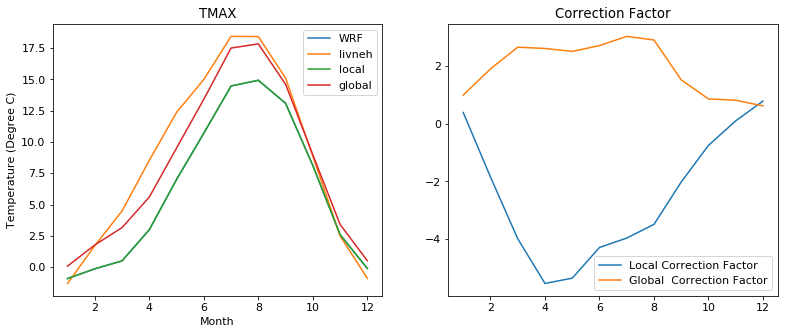

In [118]:
plt.figure(figsize=(13,5))
plt.rcParams.update({'font.size': 11}) 

plt.subplot(1,2,1)
plt.title('TMAX')
plt.plot(ltm_skook['month_TMAX_dailywrf_salathe2014'][0])
plt.plot(ltm_skook['month_TMAX_dailymet_livneh2013'][0])
plt.plot(ltm_skook['month_TMAX_dailymet_livneh2013_wrfbc'][0])
plt.plot(ltm_skook['month_TMAX_dailymet_livneh2013_wrfbc_global'][0])
plt.legend(['WRF', 'livneh','local','global'])
plt.xlabel('Month')
plt.ylabel('Temperature (Degree C)')
#plt.legend()

plt.subplot(1,2,2)
plt.title('Correction Factor')
plt.plot(BiasCorr_wrfbc_skook['TMAX_skookum'][0])
plt.plot(Global_BiasCorr_wrfbc_skook['TMAX_skookum'][0])
plt.legend(['Local Correction Factor','Global  Correction Factor'])
#print('Precipitation values are a ratio of WRF_m/Liv_m and Temperature values are the difference between WRF_m-Liv_m')
plt.savefig('./monthly_bc_tmax.png',dpi=400)

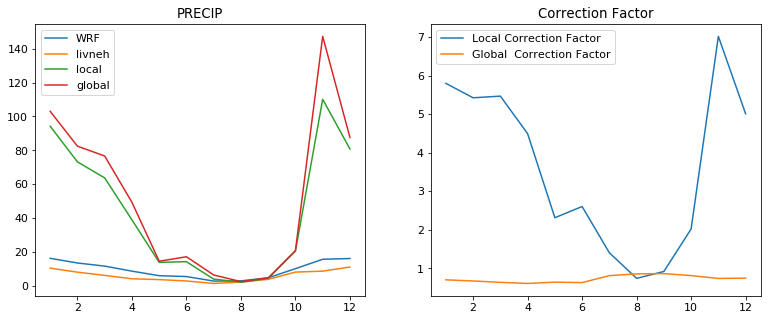

In [120]:
plt.figure(figsize=(13,5))
plt.rcParams.update({'font.size': 11}) 

plt.subplot(1,2,1)
plt.title('PRECIP')
plt.plot(ltm_skook['month_PRECIP_dailywrf_salathe2014'][0])
plt.plot(ltm_skook['month_PRECIP_dailymet_livneh2013'][0])
plt.plot(ltm_skook['month_PRECIP_dailymet_livneh2013_wrfbc'][0])
plt.plot(ltm_skook['month_PRECIP_dailymet_livneh2013_wrfbc_global'][0])
plt.legend(['WRF', 'livneh','local','global'])
#plt.legend()

plt.subplot(1,2,2)
plt.title('Correction Factor')
plt.plot(BiasCorr_wrfbc_skook['PRECIP_skookum'][0])
plt.plot(Global_BiasCorr_wrfbc_skook['PRECIP_skookum'][0])
plt.legend(['Local Correction Factor','Global  Correction Factor'])
#print('Precipitation values are a ratio of WRF_m/Liv_m and Temperature values are the difference between WRF_m-Liv_m')
plt.savefig('./monthly_bc_precip.png',dpi=400)

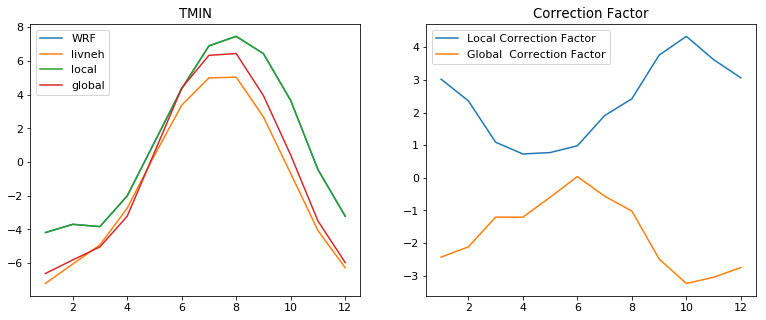

In [122]:
plt.figure(figsize=(13,5))
plt.rcParams.update({'font.size': 11}) 

plt.subplot(1,2,1)
plt.title('TMIN')
plt.plot(ltm_skook['month_TMIN_dailywrf_salathe2014'][0])
plt.plot(ltm_skook['month_TMIN_dailymet_livneh2013'][0])
plt.plot(ltm_skook['month_TMIN_dailymet_livneh2013_wrfbc'][0])
plt.plot(ltm_skook['month_TMIN_dailymet_livneh2013_wrfbc_global'][0])
plt.legend(['WRF', 'livneh','local','global'])
#plt.legend()

plt.subplot(1,2,2)
plt.title('Correction Factor')
plt.plot(BiasCorr_wrfbc_skook['TMIN_skookum'][0])
plt.plot(Global_BiasCorr_wrfbc_skook['TMIN_skookum'][0])
plt.legend(['Local Correction Factor','Global  Correction Factor'])
#print('Precipitation values are a ratio of WRF_m/Liv_m and Temperature values are the difference between WRF_m-Liv_m')
plt.savefig('./monthly_bc_tmin.png',dpi=400)

In [123]:
sorted(ltm_skook.keys())

['PRECIP_dailymet_livneh2013',
 'PRECIP_dailymet_livneh2013_wrfbc',
 'PRECIP_dailymet_livneh2013_wrfbc_global',
 'PRECIP_dailywrf_salathe2014',
 'TMAX_dailymet_livneh2013',
 'TMAX_dailymet_livneh2013_wrfbc',
 'TMAX_dailymet_livneh2013_wrfbc_global',
 'TMAX_dailywrf_salathe2014',
 'TMIN_dailymet_livneh2013',
 'TMIN_dailymet_livneh2013_wrfbc',
 'TMIN_dailymet_livneh2013_wrfbc_global',
 'TMIN_dailywrf_salathe2014',
 'WINDSPD_dailymet_livneh2013',
 'WINDSPD_dailymet_livneh2013_wrfbc',
 'WINDSPD_dailymet_livneh2013_wrfbc_global',
 'WINDSPD_dailywrf_salathe2014',
 'anom_year_PRECIP_dailymet_livneh2013',
 'anom_year_PRECIP_dailymet_livneh2013_wrfbc',
 'anom_year_PRECIP_dailymet_livneh2013_wrfbc_global',
 'anom_year_PRECIP_dailywrf_salathe2014',
 'anom_year_TMAX_dailymet_livneh2013',
 'anom_year_TMAX_dailymet_livneh2013_wrfbc',
 'anom_year_TMAX_dailymet_livneh2013_wrfbc_global',
 'anom_year_TMAX_dailywrf_salathe2014',
 'anom_year_TMIN_dailymet_livneh2013',
 'anom_year_TMIN_dailymet_livneh2013_

##### Print Maximum Annual Preciptation for different products and locations


In [124]:
print(ltm_skook['meanyear_PRECIP_dailymet_livneh2013'].max(axis=0))
print(ltm_skook['meanyear_PRECIP_dailywrf_salathe2014'].max(axis=0))


8.834777400547946
10.526569863013702


## Save to hydroshare

In [125]:
from hs_restclient import HydroShare
hs = HydroShare()
hs_up = hydroshare.hydroshare()
notebook_file = './OGH_skookum_hybrid_20200302.ipynb'

Successfully established a connection with HydroShare


In [ ]:
# write meta data such as abstract, title, keywords, resource type
#abstract = 'Notebook for Puyallup Bias-correction'
##title = 'Jupyter notebook Puyallup BC'
#keywords = ('OGH', 'Puyallup', 'notebook') # currently you need to include at least two keywords or the upload will fail
#resource_type = 'genericresource'
#files = notebook_file, # yes, you do need the comma after the file here. It's a python thing (tuple)


## 7. Apply Hybrid Bias to Future Data (Livneh2013MACA)

In [ ]:
#maptable.columns[8:]
maptable['bcc-csm1-1-m__rcp45']

In [ ]:
meta_MACA_file['CSIRO-Mk3-6-0__rcp45']['date_range']['start']

In [ ]:
for eachcol in maptable.columns[8:]:
    #if eachcol == 'bcc-csm1-1-m__rcp45'
    start_catalog_label1=eachcol
    end_catalog_label1=eachcol+'_wrfbc'
    dest_dir1=eachcol+'_wrfbc'
    Daily_MET_1915_2011_WRFbc, meta_file = ogh.makebelieve(homedir=homedir,
                                                           mappingfile=mappingfile1,
                                                           BiasCorr=BiasCorr_wrfbc_skook,
                                                           metadata=meta_MACA_file,
                                                           start_catalog_label=start_catalog_label1,
                                                           end_catalog_label=end_catalog_label1, 
                                                           file_start_date=meta_MACA_file[start_catalog_label1]['date_range']['start'],
                                                           file_end_date=meta_MACA_file[start_catalog_label1]['date_range']['end'],
                                                           data_dir=None,
                                                           dest_dir_suffix=dest_dir1)
    start_catalog_label2=end_catalog_label1
    end_catalog_label2=eachcol+'_wrfbc_global'
    dest_dir2=eachcol+'_wrfbc_global'
    Daily_MET_1915_2011_WRFbc_global, meta_file = ogh.makebelieve(homedir=homedir,
                                                           mappingfile=mappingfile1,
                                                           BiasCorr=Global_BiasCorr_wrfbc_skook,
                                                           metadata=meta_MACA_file,
                                                           start_catalog_label=start_catalog_label2,
                                                           end_catalog_label=end_catalog_label2, 
                                                           file_start_date=meta_MACA_file[start_catalog_label2]['date_range']['start'],
                                                           file_end_date=meta_MACA_file[start_catalog_label2]['date_range']['end'],
                                                           data_dir=None,
                                                           dest_dir_suffix=dest_dir2)

In [ ]:
for each2map in ['IPSL-CM5A-MR__rcp45','IPSL-CM5A-MR__rcp45_wrfbc','IPSL-CM5A-MR__rcp45_wrfbc_global']:
    ltm_skook = ogh.gridclim_dict(mappingfile=mappingfile1,
                               metadata=meta_file,
                               dataset=each2map,
                               file_start_date=meta_MACA_file[start_catalog_label2]['date_range']['start'],
                               file_end_date=meta_MACA_file[start_catalog_label2]['date_range']['end'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1],
                               df_dict=ltm_skook)

## 8.  Compare Corrected Future Hydrometeorology to Historic percent correction

## 9.  Make Beautiful Maps 

In [126]:
# graphical control libraries
import matplotlib as mpl
# mpl.use('agg')
import matplotlib.pyplot as plt


# shape and layer libraries
import fiona
import shapely.ops
from shapely.geometry import MultiPolygon, shape, point, box
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd

def renderValuesInPoints_scale(vardf, vardf_dateindex, vardfmin, vardfmax, shapefile, outfilepath, plottitle, colorbar_label,
                         spatial_resolution=1/16, margin=0.5, epsg=3857,
                         basemap_image='Canvas/World_Dark_Gray_Base', cmap='coolwarm'):
    """
    A function to render the dynamics across gridded cell centroids on the spatial landscape
    
    vardf: (dataframe) a time-series dataframe for a variable with time-points (rows) and gridded cell centroids (column)
    vardf_dateindex: (datetime or float) a datetime identifier to extract a row of data for visualization
    shapefile: (dir) the path to a shapefile
    outfilepath: (dir) the path for the output image file
    plottitle: (str) the title of the plot
    colorbar_label: (str) the label for the colorbar
    spatial_resolution: (float) the degree of longitude-latitude separation between gridded cell centroids, e.g., 1/16
    margin: (float) the fraction of width and height to view outside of the watershed shapefile
    epsg: (int) the epsg code for regional projection, e.g. 3857
    basemap_image: (str) the basemap arcgis service e.g., 'Canvas/World_Dark_Gray_Base' or 'ESRI_Imagery_World_2D'
    cmap: (str) the code for matplotlib colormaps, e.g. 'coolwarm',
    """
    
    # generate the figure axis
    fig = plt.figure(figsize=(2,2), dpi=500)
    ax1 = plt.subplot2grid((1,1),(0,0))

    # generate the polygon color-scheme
    cmap = mpl.cm.get_cmap(cmap)
    norm = mpl.colors.Normalize(vardfmin, vardfmax)
    color_producer = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    # calculate bounding box based on the watershed shapefile
    watershed = fiona.open(shapefile)
    minx, miny, maxx, maxy = watershed.bounds
    w, h = maxx - minx, maxy - miny
    watershed.close()
    
    # generate basemap
    m = Basemap(projection='merc', epsg=epsg, resolution='h', ax=ax1,
                llcrnrlon=minx-margin*w, llcrnrlat=miny-margin*h, urcrnrlon=maxx+margin*w, urcrnrlat=maxy+margin*h)
    m.arcgisimage(service=basemap_image, xpixels=500)
                         
    # watershed
    m.readshapefile(shapefile=shapefile.replace('.shp',''), name='watershed', drawbounds=True, color='k')
    
    # variable dataframe
    midpt=spatial_resolution/2
    crs={'init':'epsg:{0}'.format(epsg)}
    cat=vardf.T.reset_index(level=[1,2]).rename(columns={'level_1':'LAT','level_2':'LONG_'})
    geometry = cat.apply(lambda x: 
                         shapely.ops.transform(m, box(x['LONG_']-midpt, x['LAT']-midpt, 
                                                      x['LONG_']+midpt, x['LAT']+midpt)), axis=1)
    cat = gpd.GeoDataFrame(cat, crs=crs, geometry=geometry).reset_index(drop=True)

    # geopandas print
    cat.plot(column=vardf_dateindex, cmap=cmap, alpha=0.4, ax=ax1,
             vmin=vardfmin, vmax=vardfmax)

    # assimilate the shapes to plot
    patches = []
    for ind, eachpol in cat.iterrows():
        patches.append(PolygonPatch(eachpol['geometry'], linewidth=0, zorder=5.0,
                                    fc=color_producer.to_rgba(eachpol[vardf_dateindex])))

    # assimilate shapes into a patch collection
    coll = PatchCollection(patches, cmap=cmap, match_original=True, zorder=10.0)
    
    # generate colorbar
    coll.set_array(vardf.values.flatten())
    coll.set_clim([vardfmin, vardfmax])
    cbar = plt.colorbar(coll, shrink=0.5)
    cbar.ax.set_ylabel(colorbar_label, rotation=270, size=3, labelpad=5) # colorbar label
    cbar.ax.tick_params(labelsize=3) # colorbar tick fontsize

    # save image
    plt.title(plottitle, fontsize=3)
    plt.savefig(outfilepath)
    plt.show()

In [127]:
def renderValuesInPoints(vardf, vardf_dateindex, shapefile, outfilepath, plottitle, colorbar_label,
                         vmin=None, vmax=None, spatial_resolution=1/16, margin=0.5, gridcell_alpha=0.5, epsg=3857,
                         basemap_image='Canvas/World_Dark_Gray_Base', cmap='coolwarm', figsize=(2, 2)):
    """
    A function to render the dynamics across gridded cell centroids on the spatial landscape
    vardf: (dataframe) a time-series dataframe for a variable with time-points (rows) and gridded cell centroids (column)
    vardf_dateindex: (datetime or float) a datetime identifier to extract a row of data for visualization
    shapefile: (dir) the path to a shapefile
    outfilepath: (dir) the path for the output image file
    plottitle: (str) the title of the plot
    colorbar_label: (str) the label for the colorbar
    spatial_resolution: (float) the degree of longitude-latitude separation between gridded cell centroids, e.g., 1/16
    margin: (float) the fraction of width and height to view outside of the watershed shapefile
    epsg: (int) the epsg code for regional projection, e.g. 3857
    basemap_image: (str) the basemap arcgis service e.g., 'Canvas/World_Dark_Gray_Base' or 'ESRI_Imagery_World_2D'
    cmap: (str) the code for matplotlib colormaps, e.g. 'coolwarm',
    """
    # generate the figure axis
    fig = plt.figure(figsize=figsize, dpi=500)
    ax1 = plt.subplot2grid((1, 1), (0, 0))

    # set params
    if isinstance(vmin, type(None)):
        vmin = vardf.values.flatten().min()

    if isinstance(vmax, type(None)):
        vmax = vardf.values.flatten().max()

    # generate the polygon color-scheme
    cmap = mpl.cm.get_cmap(cmap)
    norm = mpl.colors.Normalize(vmin, vmax)
    color_producer = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    # calculate bounding box based on the watershed shapefile
    watershed = fiona.open(shapefile)
    minx, miny, maxx, maxy = watershed.bounds
    w, h = maxx - minx, maxy - miny
    watershed.close()

    # generate basemap
    m = Basemap(projection='merc', epsg=epsg, resolution='h', ax=ax1,
                llcrnrlon=minx-margin*w, llcrnrlat=miny-margin*h, urcrnrlon=maxx+margin*w, urcrnrlat=maxy+margin*h)
    m.arcgisimage(service=basemap_image, xpixels=500)

    # watershed
    m.readshapefile(shapefile=shapefile.replace('.shp', ''), name='watershed', drawbounds=True, linewidth=1, color='m')

    # variable dataframe
    midpt = spatial_resolution/2
    crs = {'init': 'epsg:{0}'.format(epsg)}
    cat = vardf.T.reset_index(level=[1, 2]).rename(columns={'level_1': 'LAT', 'level_2': 'LONG_'})
    geometry = cat.apply(lambda x: shapely.ops.transform(m, box(x['LONG_'] - midpt, x['LAT'] - midpt,
                                                                x['LONG_'] + midpt, x['LAT'] + midpt)), axis=1)
    cat = gpd.GeoDataFrame(cat, crs=crs, geometry=geometry).reset_index(drop=True)

    # geopandas print
    cat.plot(column=vardf_dateindex, cmap=cmap, alpha=gridcell_alpha, ax=ax1, vmin=vmin, vmax=vmax)

    # assimilate the shapes to plot
    patches = []
    for ind, eachpol in cat.iterrows():
        patches.append(PolygonPatch(eachpol['geometry'], linewidth=0, zorder=5.0,
                                    fc=color_producer.to_rgba(eachpol[vardf_dateindex])))

    # assimilate shapes into a patch collection
    coll = PatchCollection(patches, cmap=cmap, match_original=True, zorder=10.0)

    # generate colorbar
    coll.set_array(vardf.values.flatten())
    coll.set_clim([vmin, vmax])
    cbar = plt.colorbar(coll, shrink=0.5)
    cbar.ax.set_ylabel(colorbar_label, rotation=270, size=3, labelpad=3)  # colorbar label
    cbar.ax.tick_params(labelsize=2)  # colorbar tick fontsize
    cbar.outline.set_visible(False)  # colorbar outline

    # save image
    plt.title(plottitle, fontsize=3)
    plt.savefig(outfilepath)
    plt.show()

### Precipitation

In [ ]:
for eachdict, region, shp in zip([ltm_skook], ['Skookum'],[skookum]):
    for eachdf, product in zip(['PRECIP_IPSL-CM5A-MR__rcp45','PRECIP_IPSL-CM5A-MR__rcp45_wrfbc', 'PRECIP_IPSL-CM5A-MR__rcp45_wrfbc_global','PRECIP_dailymet_livneh2013'], 
                               ['IPSL-CM5A-MR__rcp45','IPSL-CM5A-MR__rcp45_Hybrid-1','IPSL-CM5A-MR__rcp45_Hydrid','OBS']):
        
        # variable time-series
        ts = eachdict[eachdf].groupby(pd.TimeGrouper("A")).sum().mean(axis=0)
        eachdict['mean_annualsum_'+eachdf] = pd.DataFrame(ts).T
        
        # generate spatial map for mean annual sum P
        renderValuesInPoints(vardf=eachdict['mean_annualsum_'+eachdf],
                             vardf_dateindex=0,
                             shapefile=shp,
                             outfilepath=os.path.join(homedir, '{0}{1}Precip.png'.format(region,product)),
                             plottitle=region+' Watershed'+'\n Mean Annual Precipitation - ' + product,
                             colorbar_label='Mean annual precipitation (mm)',
                             spatial_resolution=1/16, margin=0.15, epsg=3857,
                             basemap_image='Elevation/World_Hillshade',
                             cmap='viridis_r')

In [ ]:
for eachdict, region, shp,vmin, vmax in zip([ltm_skook], ['Skookum'],[skookum]): 
                                           [1000,1000,1000],[5000,5000,5000]):
    for eachdf, product in zip(['PRECIP_IPSL-CM5A-MR__rcp45','PRECIP_IPSL-CM5A-MR__rcp45_wrfbc', 'PRECIP_IPSL-CM5A-MR__rcp45_wrfbc_global','PRECIP_dailymet_livneh2013','PRECIP_dailymet_livneh2013_wrfbc_global'], 
                               ['IPSL-CM5A-MR__rcp45','IPSL-CM5A-MR__rcp45_Hybrid-1','IPSL-CM5A-MR__rcp45_Hydrid','OBS','Historical Hybrid']):
        
        # variable time-series
        ts = eachdict[eachdf].groupby(pd.TimeGrouper("A")).sum().mean(axis=0)
        eachdict['mean_annualsum_'+eachdf] = pd.DataFrame(ts).T
        
        # generate spatial map for mean annual sum P
        renderValuesInPoints_scale(vardf=eachdict['mean_annualsum_'+eachdf],
                             vardf_dateindex=0,
                             vardfmin=vmin,
                             vardfmax=vmax,
                             shapefile=shp,
                             outfilepath=os.path.join(homedir, '{0}{1}Precip.png'.format(region,product)),
                             plottitle=region+' Watershed'+'\n Mean Annual Precipitation - ' + product,
                             colorbar_label='Mean annual precipitation (mm)',
                             spatial_resolution=1/16, margin=0.15, epsg=3857,
                             basemap_image='Elevation/World_Hillshade',
                             cmap='viridis_r')

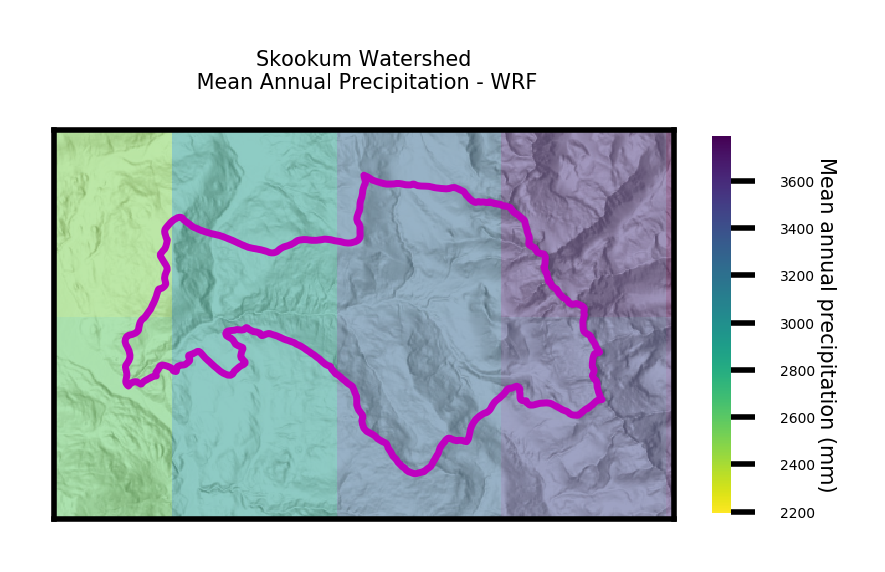

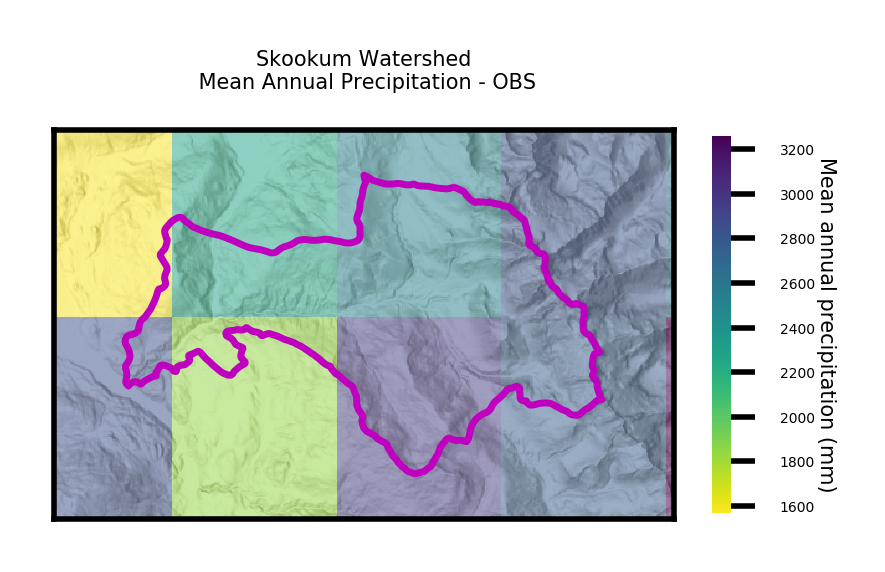

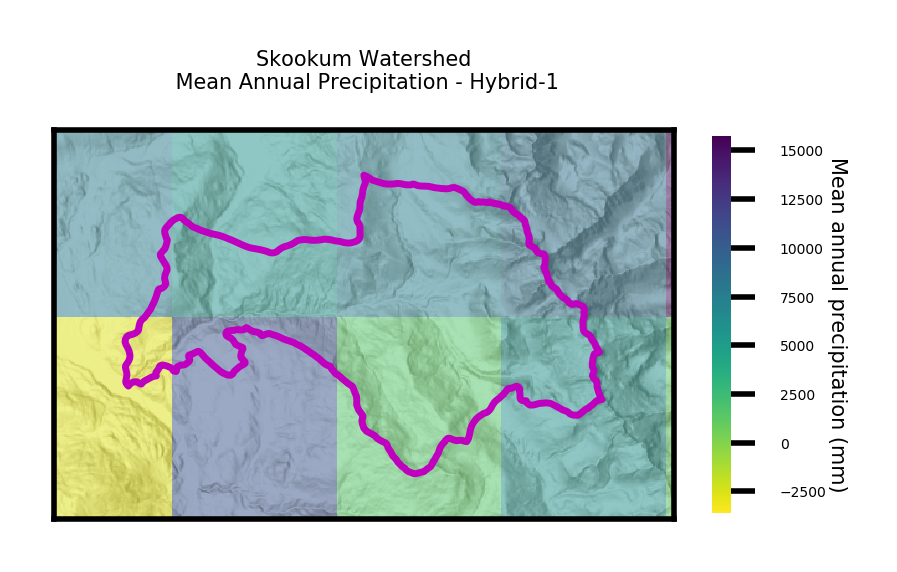

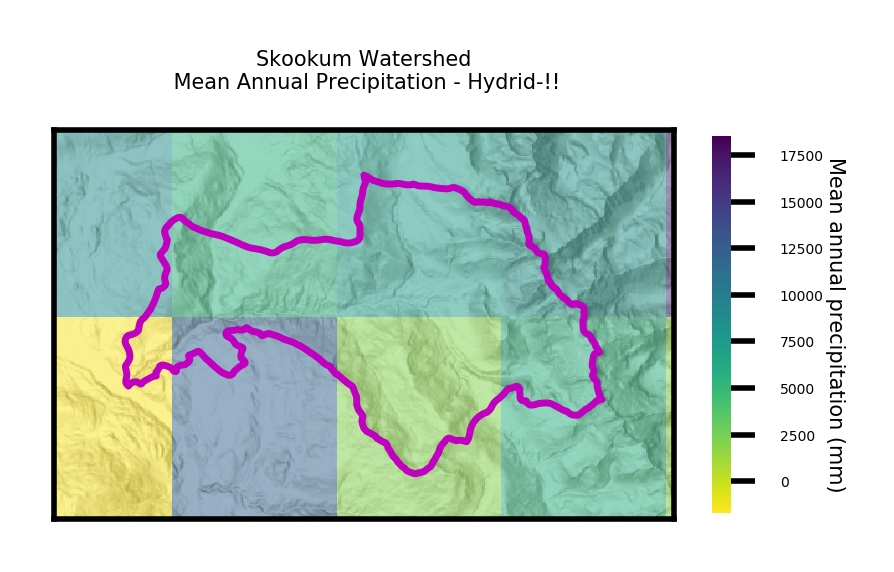

<Figure size 432x288 with 0 Axes>

In [128]:
for eachdict, region, shp in zip([ltm_skook], ['Skookum'], [skookum]):
    for eachdf, product in zip(['PRECIP_dailywrf_salathe2014', 'PRECIP_dailymet_livneh2013', 'PRECIP_dailymet_livneh2013_wrfbc', 'PRECIP_dailymet_livneh2013_wrfbc_global' ], ['WRF', 'OBS','Hybrid-1','Hydrid-!!']):
        
        # variable time-series
        ts = eachdict[eachdf].groupby(pd.TimeGrouper("Y")).sum().mean(axis=0)
        eachdict['mean_annualsum_'+eachdf] = pd.DataFrame(ts).T
        
        # generate spatial map for mean annual sum P
        renderValuesInPoints(vardf=eachdict['mean_annualsum_'+eachdf],
                             vardf_dateindex=0,
                             shapefile=shp,
                             outfilepath=os.path.join(homedir, '{0}{1}Precip.png'.format(region,product)),
                             plottitle=region+' Watershed'+'\n Mean Annual Precipitation - ' + product,
                             colorbar_label='Mean annual precipitation (mm)',
                             spatial_resolution=1/16, margin=0.15, epsg=3857,
                             basemap_image='Elevation/World_Hillshade',
                             cmap='viridis_r')
plt.savefig('\mean_annual_precipitation.png')

In [129]:

for eachdict, region, shp in zip([ltm_skook, ltm_skook, ltm_skook], ['Skookum','Skookum','Skookum'], [skagit, sauk, upperforks]):
    for eachdf, product in zip(['PRECIP_dailywrf_salathe2014', 'PRECIP_dailymet_livneh2013'], ['WRF', 'OBS']):
        
        # variable time-series
        ts = eachdict[eachdf].groupby(pd.TimeGrouper("Y")).sum().mean(axis=0)
        eachdict['mean_annualsum_'+eachdf] = pd.DataFrame(ts).T
        
        # generate spatial map for mean annual sum P
        renderValuesInPoints_scale(vardf=eachdict['mean_annualsum_'+eachdf],
                             vardf_dateindex=0,
                             vardfmin=vmin,
                             vardfmax=vmax,
                             shapefile=shp,
                             outfilepath=os.path.join(homedir, '{0}{1}Precip.png'.format(region,product)),
                             plottitle=region+' Watershed'+'\n Mean Annual Precipitation - ' + product,
                             colorbar_label='Mean annual precipitation (mm)',
                             spatial_resolution=1/16, margin=0.15, epsg=3857,
                             basemap_image='Elevation/World_Hillshade',
                             cmap='viridis_r')

NameError: name 'skagit' is not defined

In [ ]:
for eachdict, region, shp, vmin, vmax in zip([ltm_skagit],
                                             ['Puyallup'], 
                                             [puyallup],
                                             [700,1400,2000],
                                             [5304,3500,3500]):
    for eachdf, product in zip(['PRECIP_dailywrf_salathe2014', 'PRECIP_dailymet_livneh2013', 'PRECIP_dailymet_livneh2013_wrfbc', 'PRECIP_dailymet_livneh2013_wrfbc_global'], ['WRF', 'OBS','Hybrid-1','Hydrid-!!']):
        
        # variable time-series
        ts = eachdict[eachdf].groupby(pd.TimeGrouper("Y")).sum().mean(axis=0)
        eachdict['mean_annualsum_'+eachdf] = pd.DataFrame(ts).T
        
        # generate spatial map for mean annual sum P
        renderValuesInPoints_scale(vardf=eachdict['mean_annualsum_'+eachdf],
                             vardf_dateindex=0,
                             vardfmin=vmin,
                             vardfmax=vmax,
                             shapefile=shp,
                             outfilepath=os.path.join(homedir, '{0}{1}Precip.png'.format(region,product)),
                             plottitle=region+' Watershed'+'\n Mean Annual Precipitation - ' + product,
                             colorbar_label='Mean annual precipitation (mm)',
                             spatial_resolution=1/16, margin=0.15, epsg=3857,
                             basemap_image='Elevation/World_Hillshade',
                             cmap='viridis_r')

plt.savefig('../../../../../../puyallup/mean_annual_precipitation_bc.png')

In [ ]:
for eachdict, region, shp, vmin, vmax in zip([ltm_skagit, ltm_sauk, ltm_upperforks],
                                             ['Skagit','Sauk','Upperforks'], 
                                             [skagit, sauk, upperforks],
                                             [700,1400,2000],
                                             [5304,3500,3500]):
    for eachdf, product in zip(['PRECIP_dailywrf_salathe2014', 'PRECIP_dailymet_livneh2013'], ['WRF', 'OBS']):
        
        # variable time-series
        ts = eachdict[eachdf].groupby(pd.TimeGrouper("Y")).sum().mean(axis=0)
        eachdict['mean_annualsum_'+eachdf] = pd.DataFrame(ts).T
        
        # generate spatial map for mean annual sum P
        renderValuesInPoints_scale(vardf=eachdict['mean_annualsum_'+eachdf],
                             vardf_dateindex=0,
                             vardfmin=vmin,
                             vardfmax=vmax,
                             shapefile=shp,
                             outfilepath=os.path.join(homedir, '{0}{1}Precip.png'.format(region,product)),
                             plottitle=region+' Watershed'+'\n Mean Annual Precipitation - ' + product,
                             colorbar_label='Mean annual precipitation (mm)',
                             spatial_resolution=1/16, margin=0.15, epsg=3857,
                             basemap_image='Elevation/World_Hillshade',
                             cmap='viridis_r')

### Temperature

In [136]:
for eachdict, region, shp in zip([ltm_skagit],['Skookum'],[skookum]):
    for eachdf, product in zip(['month_TMAX_dailywrf_salathe2014', 'month_TMAX_dailymet_livneh2013', 'month_TMAX_dailymet_livneh2013_wrfbc', 'month_TMAX_dailymet_livneh2013_wrfbc_global'], ['WRF', 'OBS','Hydrid-1','Hydbrid-!!']):
        
        month=11
        monthlabel = pd.datetime.strptime(str(month), '%m')
        renderValuesInPoints(vardf=eachdict[eachdf],
                         vardf_dateindex=month,
                         shapefile=shp,
                         outfilepath=os.path.join(homedir, '{0}{1}TMAX.png'.format(region,product)),
                         plottitle=region+' Watershed'+'\nTemperature Max in '+ monthlabel.strftime('%B')+'-'+product,
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')
            
plt.savefig('../../../../../../puyallup/avg_dail_max_temp.png')

NameError: name 'ltm_skagit' is not defined

In [ ]:
for eachdict, region, shp in zip([ltm_skagit, ltm_sauk, ltm_upperforks], ['Skagit','Sauk','Upperforks'], [skagit, sauk, upperforks]):
    for eachdf, product in zip(['month_TMAX_dailywrf_salathe2014', 'month_TMAX_dailymet_livneh2013'], ['WRF', 'OBS']):
        
        month=11
        monthlabel = pd.datetime.strptime(str(month), '%m')
        renderValuesInPoints(vardf=eachdict[eachdf],
                         vardf_dateindex=month,
                         shapefile=shp,
                         outfilepath=os.path.join(homedir, '{0}{1}TMAX.png'.format(region,product)),
                         plottitle=region+' Watershed'+'\nTemperature Max in '+ monthlabel.strftime('%B')+'-'+product,
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')

In [ ]:
month=11
# print(ltm_skagit['month_TMAX_dailymet_livneh2013'].max(axis=1))  #11C
# print(ltm_skagit['month_TMAX_dailywrf_salathe2014'].max(axis=1))
# print(ltm_sauk['month_TMAX_dailymet_livneh2013'].max(axis=1))  #9C
# print(ltm_sauk['month_TMAX_dailywrf_salathe2014'].max(axis=1))
# print(ltm_upperforks['month_TMAX_dailymet_livneh2013'].max(axis=1))  #6C
# print(ltm_upperforks['month_TMAX_dailywrf_salathe2014'].max(axis=1))

# print(ltm_skagit['month_TMAX_dailymet_livneh2013'].max(axis=1))  #11C
# print(ltm_skagit['month_TMAX_dailywrf_salathe2014'].max(axis=1))
# print(ltm_skagit['month_TMAX_dailymet_livneh2013_wrfbc'].max(axis=1))  #11C
# print(ltm_skagit['month_TMAX_dailymet_livneh2013_wrfbc_global'].max(axis=1))


print(ltm_skagit['month_TMAX_dailymet_livneh2013'].min(axis=1))  #11C
print(ltm_skagit['month_TMAX_dailywrf_salathe2014'].min(axis=1))
print(ltm_skagit['month_TMAX_dailymet_livneh2013_wrfbc'].min(axis=1))  #11C
print(ltm_skagit['month_TMAX_dailymet_livneh2013_wrfbc_global'].min(axis=1))

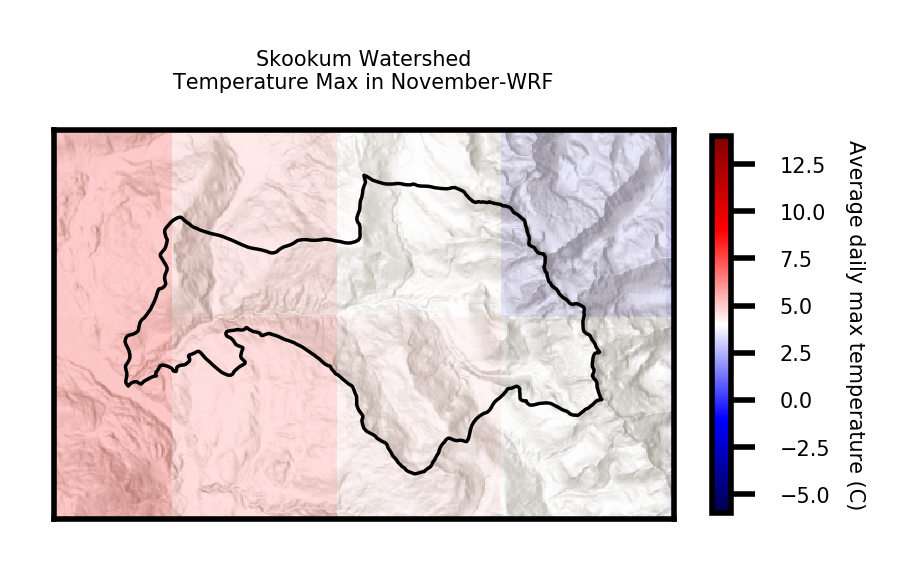

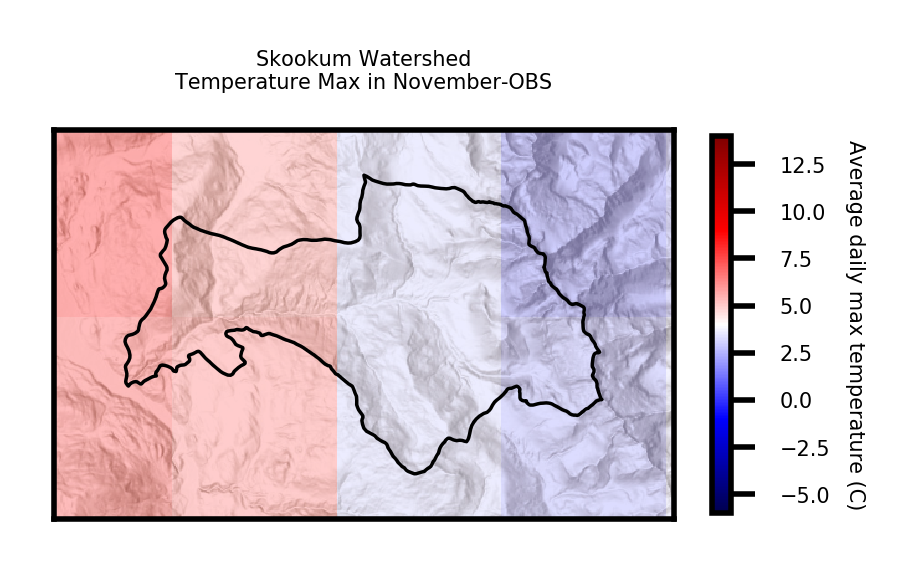

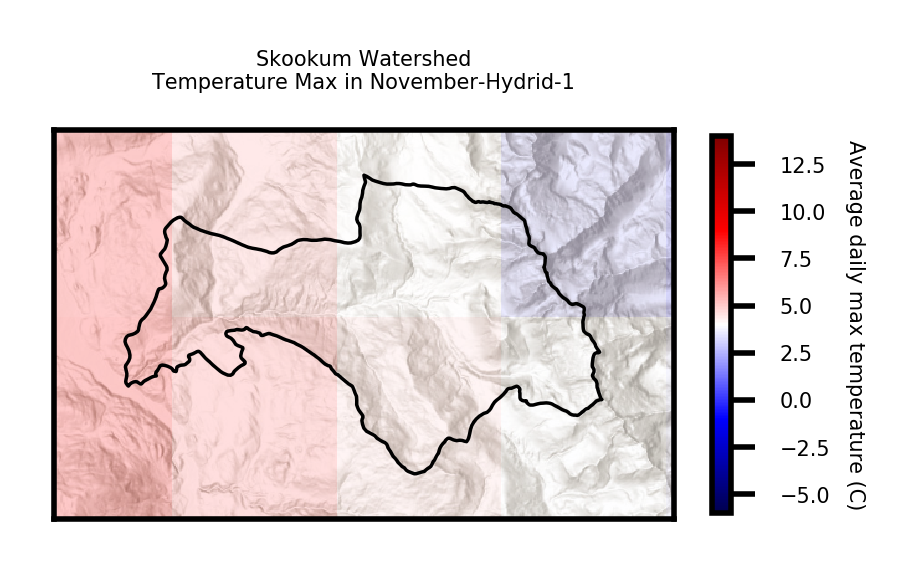

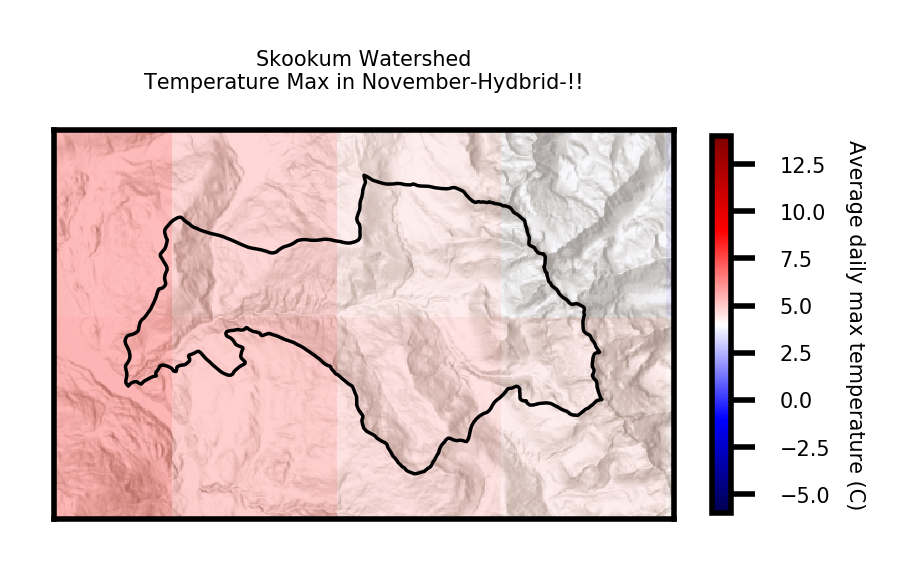

<Figure size 432x288 with 0 Axes>

In [135]:
for eachdict, region, shp, vmin, vmax in zip([ltm_skook],
                                             ['Skookum'], 
                                             [skookum],
                                             [-6,-6,-2],
                                             [14,9,6]):
    for eachdf, product in zip(['month_TMAX_dailywrf_salathe2014', 'month_TMAX_dailymet_livneh2013', 'month_TMAX_dailymet_livneh2013_wrfbc', 'month_TMAX_dailymet_livneh2013_wrfbc_global'], ['WRF', 'OBS','Hydrid-1','Hydbrid-!!']):
            month=11
            monthlabel = pd.datetime.strptime(str(month), '%m')
            renderValuesInPoints_scale(vardf=eachdict[eachdf],
                         vardf_dateindex=month,
                         vardfmin=vmin,
                         vardfmax=vmax,
                         shapefile=shp,
                         outfilepath=os.path.join(homedir, '{0}{1}TMAX.png'.format(region,product)),
                         plottitle=region+' Watershed'+'\nTemperature Max in '+ monthlabel.strftime('%B')+'-'+product,
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')
            
plt.savefig('avg_dail_max_temp_bc.png')

In [ ]:
for eachdict, region, shp, vmin, vmax in zip([ltm_skagit, ltm_sauk, ltm_upperforks],
                                             ['Skagit','Sauk','Upperforks'], 
                                             [skagit, sauk, upperforks],
                                             [-6,-6,-2],
                                             [11,9,6]):
    for eachdf, product in zip(['month_TMAX_dailywrf_salathe2014', 'month_TMAX_dailymet_livneh2013'], ['WRF', 'OBS']):
        
     
        month=11
        monthlabel = pd.datetime.strptime(str(month), '%m')
        renderValuesInPoints_scale(vardf=eachdict[eachdf],
                         vardf_dateindex=month,
                         vardfmin=vmin,
                         vardfmax=vmax,
                         shapefile=shp,
                         outfilepath=os.path.join(homedir, '{0}{1}TMAX.png'.format(region,product)),
                         plottitle=region+' Watershed'+'\nTemperature Max in '+ monthlabel.strftime('%B')+'-'+product,
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')

### Calculate number of grid cells below 0C (snowy on average)

In [138]:
ltm_skook['month_TMAX_dailywrf_salathe2014']
for eachdict, region, shp, vmin, vmax in zip([ltm_skook],
                                             ['skookum'], 
                                             [skookum],
                                             [-6,-6,-2],
                                             [11,9,6]):
    for eachdf, product in zip(['month_TMAX_dailywrf_salathe2014', 'month_TMAX_dailymet_livneh2013', 'month_TMAX_dailymet_livneh2013_wrfbc','month_TMAX_dailymet_livneh2013_wrfbc_global'], ['WRF', 'OBS','Hybrid-1','Hybrid-!!']):
                  temp = eachdict[eachdf].copy()
                  temp[temp>=0] = 0 # temperatures over 0
                  temp[temp<0] = 1 # temperatures under 0

                  # count each month average with T<0 FOR EACH MONTH
                  eachdict['freeze_month_'+eachdf] = temp.sum(axis=1)

In [139]:
ltm_skook['month_TMIN_dailywrf_salathe2014']
for eachdict, region, shp, vmin, vmax in zip([ltm_skook],
                                             ['skookum'], 
                                             [skookum],
                                             [-6,-6,-2],
                                             [11,9,6]):
    for eachdf, product in zip(['month_TMIN_dailywrf_salathe2014', 'month_TMIN_dailymet_livneh2013', 'month_TMIN_dailymet_livneh2013_wrfbc','month_TMIN_dailymet_livneh2013_wrfbc_global'], ['WRF', 'OBS','Hybrid-1','Hybrid-!!']):
                  temp = eachdict[eachdf].copy()
                  temp[temp>=-1] = 0 # temperatures over 0
                  temp[temp<-1] = 1 # temperatures under 0

                  # count each month average with T<0 FOR EACH MONTH
                  eachdict['freeze_'+eachdf] = temp.sum(axis=1)

In [141]:
sorted(ltm_skook.keys())#['freeze_month_TMAX_dailywrf_salathe2014']  
#ltm_skook['month_TMAX_dailywrf_salathe2014']
#ltm_skook['month_TMAX_dailymet_livneh2013']
#ltm_skook['month_TMAX_dailymet_livneh2013_wrfbc']
#ltm_skook['month_TMAX_dailymet_livneh2013_wrfbc_global']
#ltm_skook['freeze_month_month_TMAX_dailywrf_salathe2014']
ltm_skook['freeze_month_TMIN_dailywrf_salathe2014']

1     13.0
2      9.0
3      8.0
4      3.0
5      0.0
6      0.0
7      0.0
8      0.0
9      0.0
10     0.0
11     1.0
12     8.0
dtype: float64

In [142]:
sorted(ltm_skook.keys())#['freeze_month_TMIN_dailywrf_salathe2014']
print(ltm_skook['freeze_month_TMIN_dailywrf_salathe2014'][11]/241)
print(ltm_skook['freeze_month_TMIN_dailymet_livneh2013'][11]/241)
print(ltm_skook['freeze_month_TMIN_dailymet_livneh2013_wrfbc'][11]/241)
print(ltm_skook['freeze_month_TMIN_dailymet_livneh2013_wrfbc_global'][11]/241)
#Results for TMIN Snow at 0
0.709543568465
0.879668049793
0.709543568465
0.883817427386
#Results for TMIN Snow at -1
0.643153526971
0.850622406639
0.643153526971
0.780082987552

0.004149377593360996
0.03734439834024896
0.004149377593360996
0.04564315352697095


0.780082987552

In [ ]:
sorted(ltm_skagit.keys())#['freeze_month_TMAX_dailywrf_salathe2014']
print(ltm_skagit['freeze_month_month_TMAX_dailywrf_salathe2014'][11]/241)
print(ltm_skagit['freeze_month_month_TMAX_dailymet_livneh2013'][11]/241)
print(ltm_skagit['freeze_month_month_TMAX_dailymet_livneh2013_wrfbc'][11]/241)
print(ltm_skagit['freeze_month_month_TMAX_dailymet_livneh2013_wrfbc_global'][11]/241)
#Results for TMAX Snow at 0
# 0.327800829876
# 0.352697095436
# 0.327800829876
# 0.0912863070539
#Results for TMAX Snow at -1
0.149377593361
0.248962655602
0.149377593361
0.0

Not sure if needed

In [ ]:
year=2006
yearlabel = pd.datetime.strptime(str(year), '%Y')
renderValuesInPoints(vardf=ltm_skagit['year_PRECIP_dailymet_livneh2013'],
                         vardf_dateindex=year,
                         shapefile=skagit,
                         outfilepath=os.path.join(homedir, 'skagitPrecip{0}.png'.format(yearlabel.strftime('%Y'))),
                         plottitle='Skagit Watershed'+'\nPrecipitation in '+ yearlabel.strftime('%Y'),
                         colorbar_label='Average daily precipitation (mm)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic_r')
year=2006
yearlabel = pd.datetime.strptime(str(year), '%Y')
renderValuesInPoints(vardf=ltm_sauk['year_PRECIP_dailymet_livneh2013'],
                         vardf_dateindex=year,
                         shapefile=sauk,
                         outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(yearlabel.strftime('%Y'))),
                         plottitle='Skagit Watershed'+'\nPrecipitation in '+ yearlabel.strftime('%Y'),
                         colorbar_label='Average daily precipitation (mm)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic_r')
year=2006
yearlabel = pd.datetime.strptime(str(year), '%Y')
renderValuesInPoints(vardf=ltm_upperforks['year_PRECIP_dailymet_livneh2013'],
                         vardf_dateindex=year,
                         shapefile=upperforks,
                         outfilepath=os.path.join(homedir, 'upperforksPrecip{0}.png'.format(yearlabel.strftime('%Y'))),
                         plottitle='Skagit Watershed'+'\nPrecipitation in '+ yearlabel.strftime('%Y'),
                         colorbar_label='Average daily precipitation (mm)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic_r')

In [ ]:
month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=scale_df,
                         vardf_dateindex=month,
                         shapefile=skagit,
                         outfilepath=os.path.join(homedir, 'SkagitLivTmax{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Skagit Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')

month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_sauk['month_TMAX_dailymet_livneh2013'],
                         vardf_dateindex=month,
                         shapefile=sauk,
                         outfilepath=os.path.join(homedir, 'SaukLivTmax{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Sauk-Suiattle Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')

month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_upperforks['month_TMAX_dailymet_livneh2013'],
                         vardf_dateindex=month,
                         shapefile=upperforks,
                         outfilepath=os.path.join(homedir, 'UpperforkLivTmax{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Upper Sauk Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')

In [ ]:
month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_skagit['month_TMAX_dailywrf_salathe2014'],
                         vardf_dateindex=month,
                         shapefile=skagit,
                         outfilepath=os.path.join(homedir, 'SkagitWRFTmax{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Skagit Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')

month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_sauk['month_TMAX_dailywrf_salathe2014'],
                         vardf_dateindex=month,
                         shapefile=sauk,
                         outfilepath=os.path.join(homedir, 'SaukWRFTmax{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Sauk-Suiattle Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')

month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_upperforks['month_TMAX_dailywrf_salathe2014'],
                         vardf_dateindex=month,
                         shapefile=upperforks,
                         outfilepath=os.path.join(homedir, 'UpperforkWRFTmax{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Upper Sauk Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')

In [ ]:
sorted(ltm_skagit.keys())

In [ ]:
ltm_skagit['PRECIP_dailywrf_salathe2014']

In [ ]:
ltm_sauk['PRECIP_dailywrf_salathe2014'].mean(axis=1).plot()

In [ ]:
sorted(ltm_skagit.keys())

In [ ]:
for eachdict, region in zip([ltm_skagit, ltm_sauk, ltm_upperforks], ['skagit','sauk','upperforks']):
    for eachdf in ['PRECIP_dailywrf_salathe2014', 'PRECIP_dailymet_livneh2013','PRECIP_dailymet_livneh2013_wrfbc','PRECIP_dailymet_livneh2013_wrfbc_global']:
        
        # variable time-series
        ts = eachdict[eachdf].mean(axis=1).reset_index().rename(columns={0:'var', 'index':'date'})

        # adjust time-series into dataframe
        ts['year'] = ts.date.apply(lambda x: x.year)
        ts['month'] = ts.date.apply(lambda x: x.month)
        ts['day'] = ts.date.apply(lambda x: x.day)
        ts = ts[['year','month','day','var']]

        # output the file
        ts.to_csv(os.path.join(homedir, region+'_'+eachdf+'.txt'), sep='\t', header=False, index=False)
        
        print('DONE: '+ region+'_'+eachdf+'.txt')
        
sorted(os.listdir(homedir))

In [ ]:
for eachdict, region in zip([ltm_skagit, ltm_sauk, ltm_upperforks], ['skagit','sauk','upperforks']):
    for eachdf in ['PRECIP_dailywrf_salathe2014', 'PRECIP_dailymet_livneh2013']:
        
        # variable time-series
        ts = eachdict[eachdf].mean(axis=1).reset_index().rename(columns={0:'var', 'index':'date'})

        # adjust time-series into dataframe
        ts['year'] = ts.date.apply(lambda x: x.year)
        ts['month'] = ts.date.apply(lambda x: x.month)
        ts['day'] = ts.date.apply(lambda x: x.day)
        ts = ts[['year','month','day','var']]

        # output the file
        ts.to_csv(os.path.join(homedir, region+'_'+eachdf+'.txt'), sep='\t', header=False, index=False)
        
        print('DONE: '+ region+'_'+eachdf+'.txt')
        
sorted(os.listdir(homedir))

In [ ]:
month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_skagit['month_PRECIP_dailywrf_salathe2014'],
                         vardf_dateindex=month,
                         shapefile=skagit,
                         outfilepath=os.path.join(homedir, 'SkagitWRFPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Skagit Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily precipitation (mm)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic_r')

month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_sauk['month_PRECIP_dailywrf_salathe2014'],
                         vardf_dateindex=month,
                         shapefile=sauk,
                         outfilepath=os.path.join(homedir, 'SaukWRFPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Sauk-Suiattle Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily precipitation (mm)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic_r')

month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_upperforks['month_PRECIP_dailywrf_salathe2014'],
                         vardf_dateindex=month,
                         shapefile=upperforks,
                         outfilepath=os.path.join(homedir, 'UpperForksWRFPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Upper Sauk Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily precipitation (mm)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic_r')

In [ ]:

month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_sauk['month_PRECIP_dailymet_livneh2013'],
                         vardf_dateindex=month,
                         shapefile=sauk.replace('.shp','_2.shp'), 
                         outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average monthly precipitation (meters)',
                         spatial_resolution=1/16, margin=0.5, epsg=3857,
                         basemap_image='Demographics/USA_Social_Vulnerability_Index',
                         cmap='gray_r')

month=6
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_sauk['month_PRECIP_dailymet_livneh2013'],
                         vardf_dateindex=month,
                         shapefile=sauk.replace('.shp','_2.shp'), 
                         outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average monthly precipitation (meters)',
                         spatial_resolution=1/16, margin=0.5, epsg=3857,
                         basemap_image='ESRI_StreetMap_World_2D',
                         cmap='gray_r')


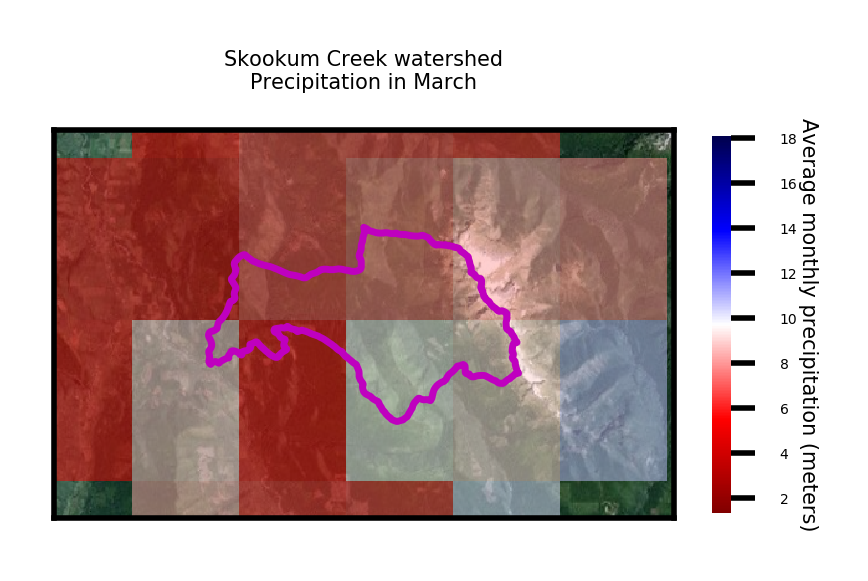

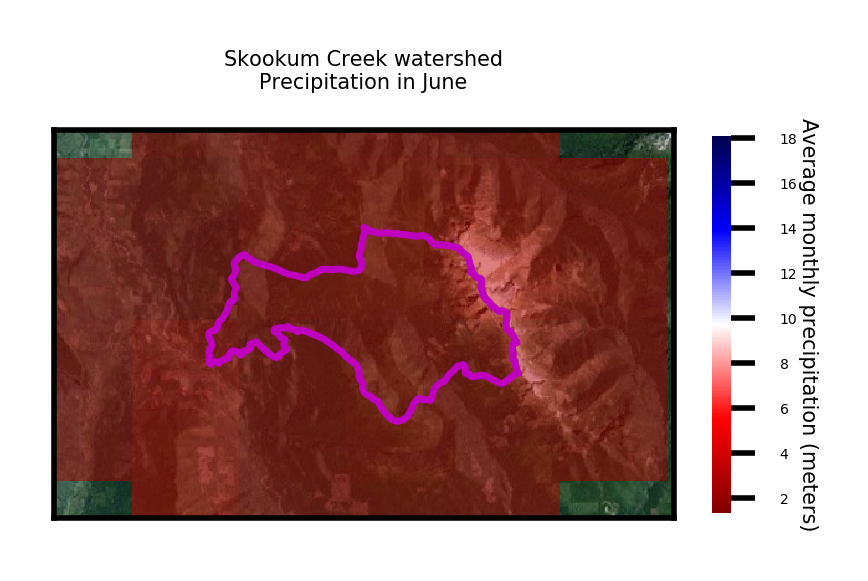

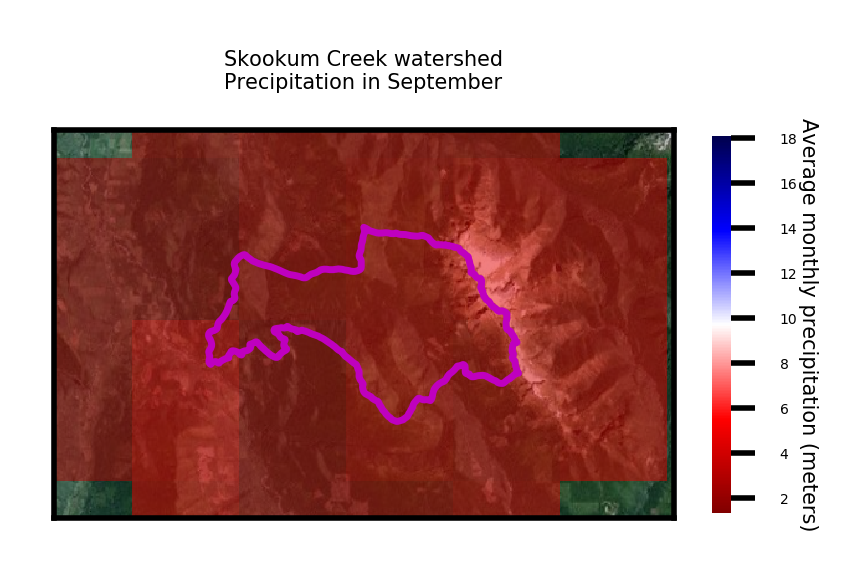

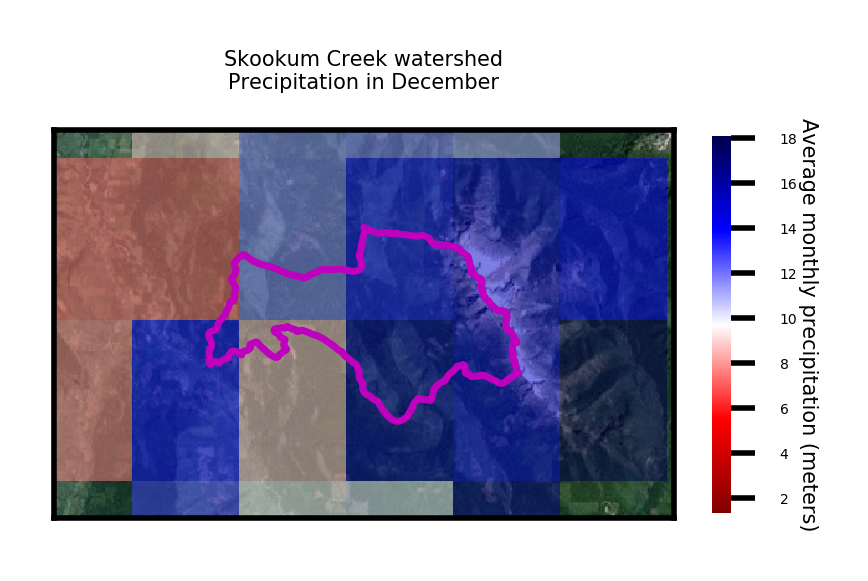

In [146]:
for month in [3, 6, 9, 12]:
    monthlabel = pd.datetime.strptime(str(month), '%m')
    outfile='SkookumLivnehPrecip{0}.png'.format(monthlabel.strftime('%b'))
    
    ax1 = renderValuesInPoints(vardf=ltm_skook['month_PRECIP_dailymet_livneh2013'],
                                   vardf_dateindex=month,
                                   shapefile=shp, 
                                   basemap_image='ESRI_Imagery_World_2D',
                                   cmap='seismic_r',
                                   plottitle='Skookum Creek watershed'+'\nPrecipitation in '+monthlabel.strftime('%B'),
                                   colorbar_label='Average monthly precipitation (meters)',
                                   outfilepath=os.path.join(homedir, outfile))

NameError: name 'df_obj' is not defined

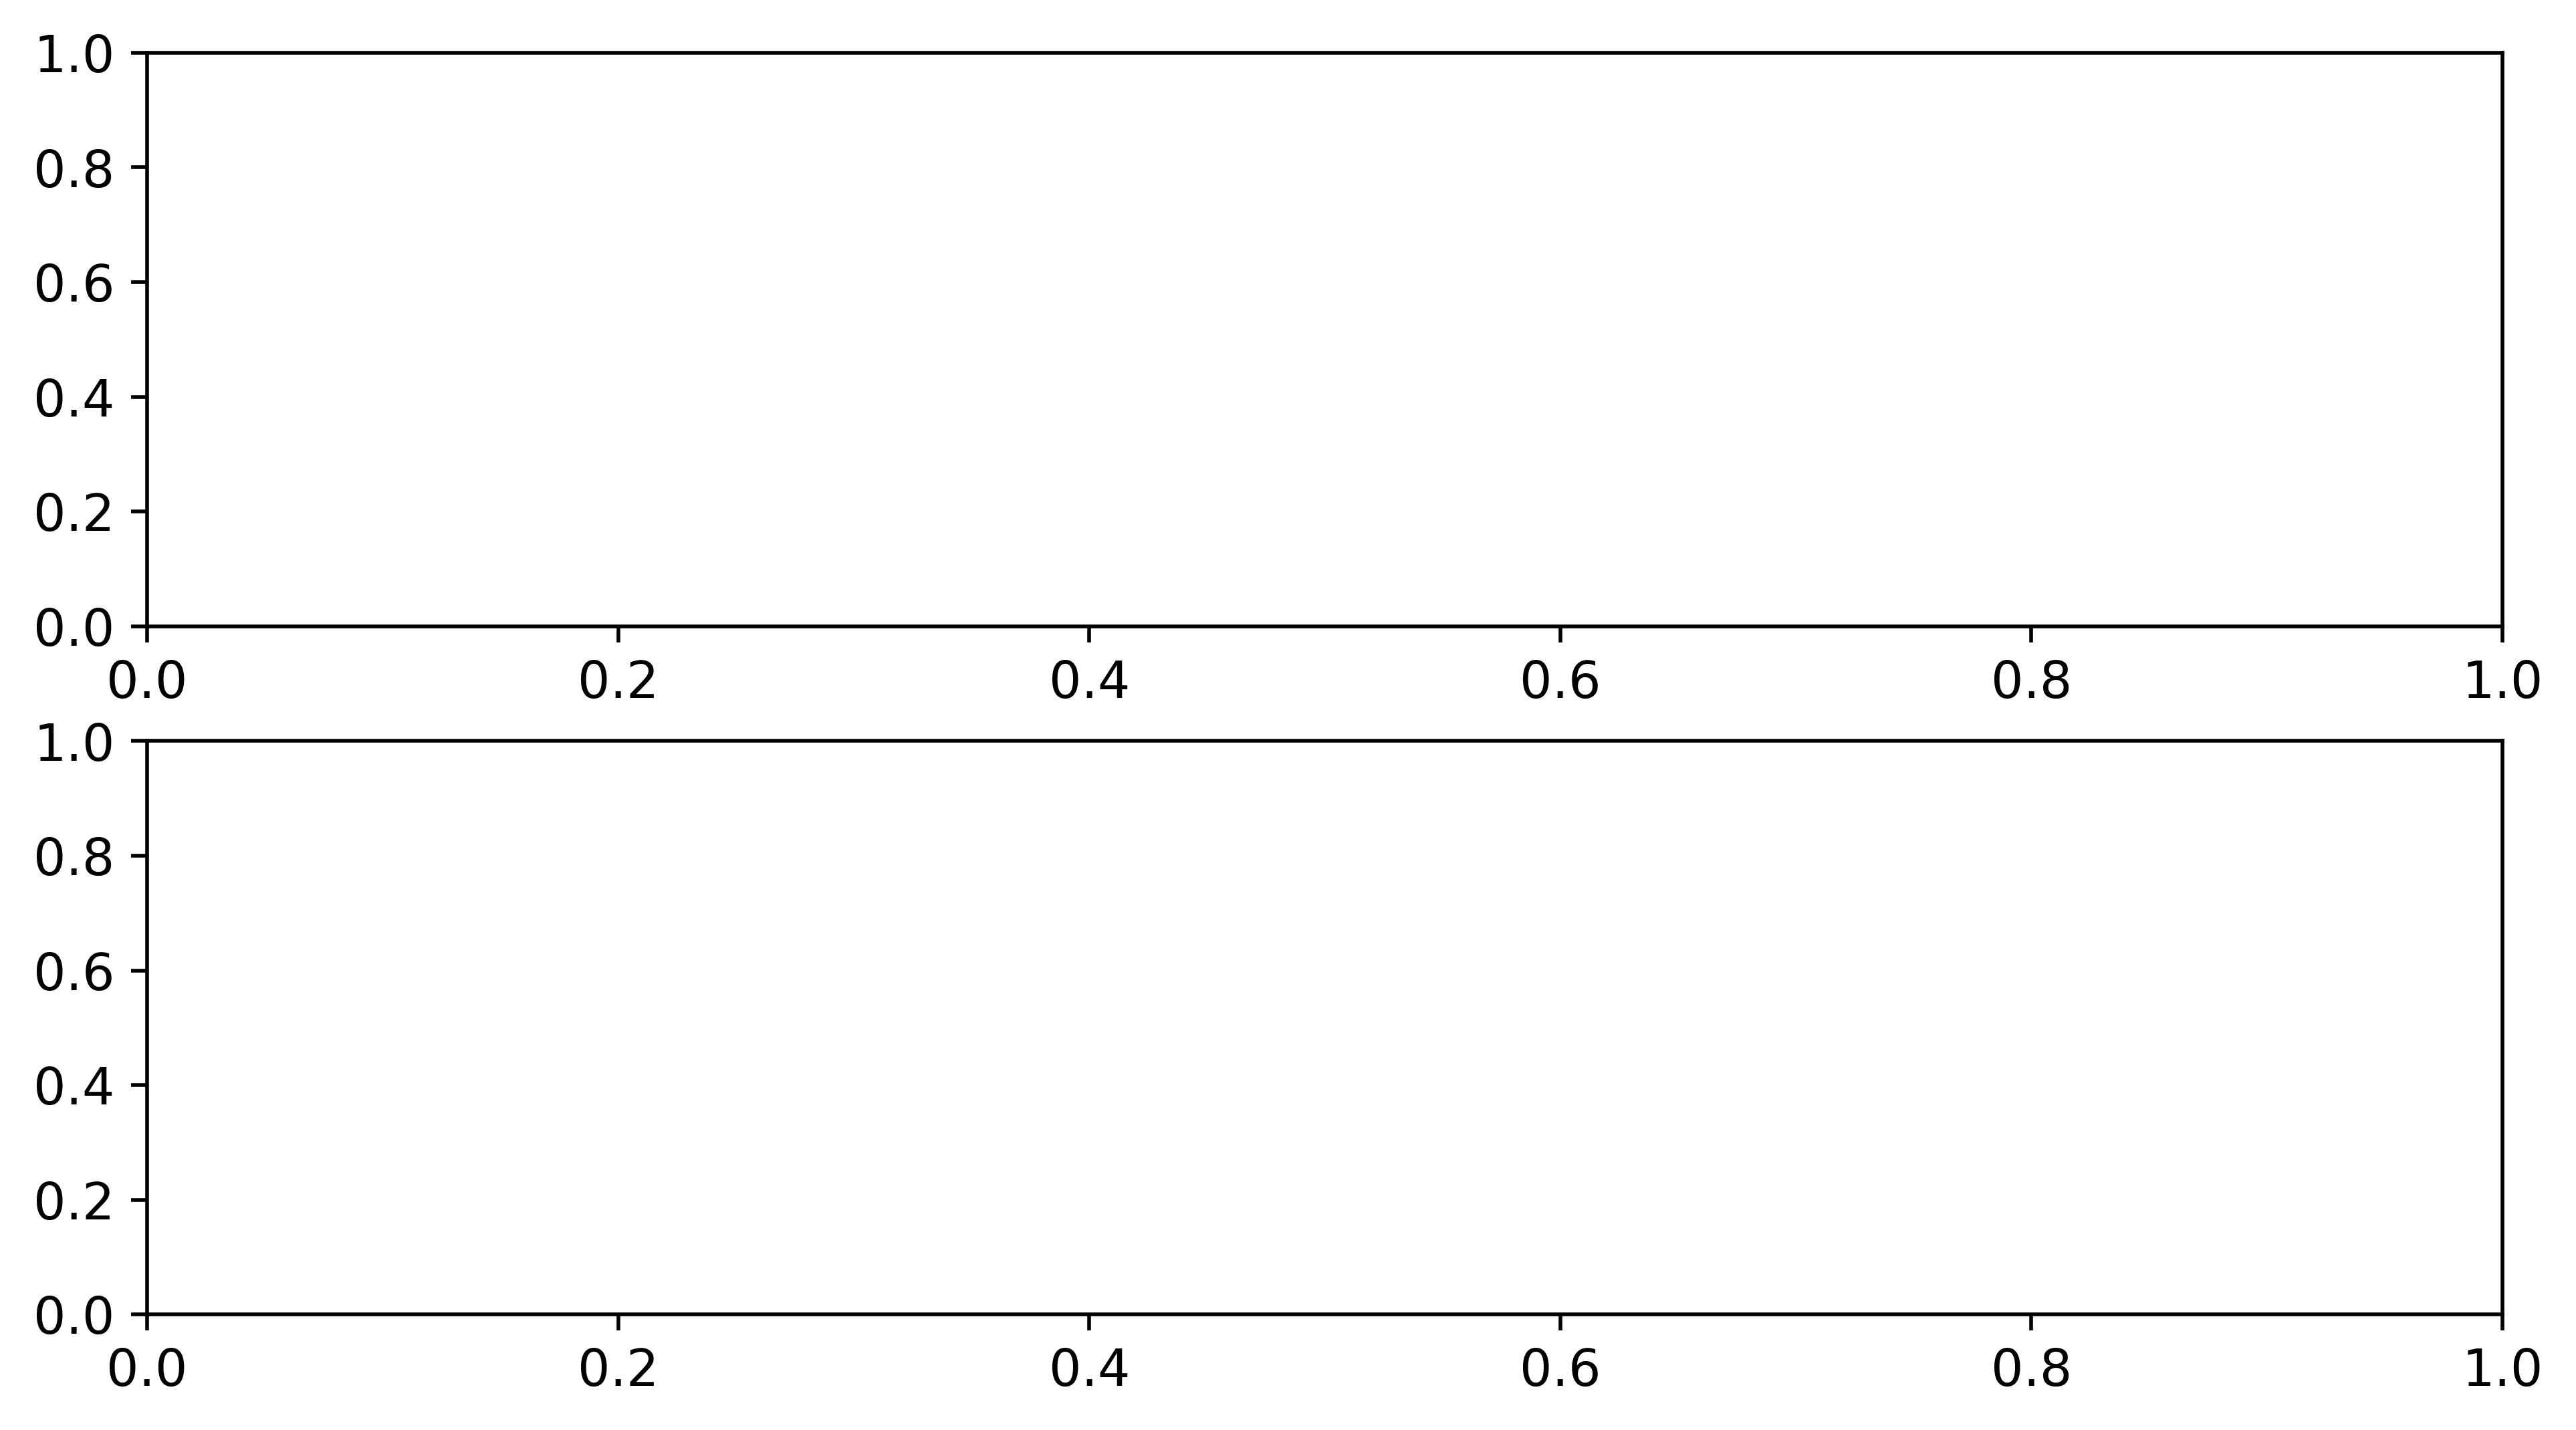

In [143]:
comp = [['meanmonth_TMAX_dailymet_livneh2013','meanmonth_TMAX_dailywrf_salathe2014'],
        ['meanmonth_PRECIP_dailymet_livneh2013','meanmonth_PRECIP_dailywrf_salathe2014']]
wy_numbers=[10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
month_strings=[ 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']


fig = plt.figure(figsize=(20,5), dpi=500)

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)


# monthly
for eachsumm in df_obj.columns:
    ax1.plot(df_obj[eachsumm])
    

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2, fontsize=10)
plt.show()

In [ ]:
df_obj[each].index.apply(lambda x: x+2)

In [ ]:
fig, ax = plt.subplots()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    panel_obj.xs(key=(minElevStation[0][0], minElevStation[0][1], minElevStation[0][2]), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
fig.show()
    

    
    
fig, ax = plt.subplots()
lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    panel_obj.xs(key=(maxElevStation[0][0], maxElevStation[0][1], maxElevStation[0][2]), 
                 axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
fig.show()

## 10. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.

In [147]:
#execute this cell to list the content of the directory
!ls -lt
!pwd
printdir = hs.getContentPath('e47aabb406bc45a28f34b97a832daa08')
printdir
os.chdir(printdir)
!pwd

total 17712
-rw-r--r-- 1 jovyan users  299486 Mar  3 08:49 SkookumLivnehPrecipDec.png
-rw-r--r-- 1 jovyan users  297896 Mar  3 08:48 SkookumLivnehPrecipSep.png
-rw-r--r-- 1 jovyan users  297336 Mar  3 08:48 SkookumLivnehPrecipJun.png
-rw-r--r-- 1 jovyan users 4385919 Mar  3 08:48 OGH_skookum_hybrid_20200302.ipynb
-rw-r--r-- 1 jovyan users  297581 Mar  3 08:47 SkookumLivnehPrecipMar.png
-rw-r--r-- 1 jovyan users    1274 Mar  3 08:40 avg_dail_max_temp_bc.png
-rw-r--r-- 1 jovyan users  347927 Mar  3 08:40 SkookumHydbrid-!!TMAX.png
-rw-r--r-- 1 jovyan users  347814 Mar  3 08:40 SkookumHydrid-1TMAX.png
-rw-r--r-- 1 jovyan users  346584 Mar  3 08:39 SkookumOBSTMAX.png
-rw-r--r-- 1 jovyan users  347628 Mar  3 08:39 SkookumWRFTMAX.png
-rw-r--r-- 1 jovyan users    1274 Mar  3 08:34 \mean_annual_precipitation.png
-rw-r--r-- 1 jovyan users  314707 Mar  3 08:34 SkookumHydrid-!!Precip.png
-rw-r--r-- 1 jovyan users  315573 Mar  3 08:34 SkookumHybrid-1Precip.png
-rw-r--r-- 1 jovyan users  314771 Mar 

AttributeError: 'HydroShare' object has no attribute 'getContentPath'

In [ ]:
#monthlabel.strftime('%B')
filename_local='bcc-csm1-1-m__rcp45'+'_wrfbc'
filename_local_tar='bcc-csm1-1-m__rcp45'+'_wrfbc_tar'
print(filename_local)
print(filename_local_tar)
!tar -zcf {filename_local_tar} 'bcc-csm1-1-m__rcp45_wrfbc'

In [ ]:
for each in ['bcc-csm1-1-m__rcp45','CanESM2__rcp45','CSIRO-Mk3-6-0__rcp45','CCSM4__rcp45','CNRM-CM5__rcp45','HadGEM2-CC365__rcp45','HadGEM2-ES365__rcp45','IPSL-CM5A-MR__rcp45','NorESM1-M__rcp45','MIROC5__rcp45','bcc-csm1-1-m__rcp85','CanESM2__rcp85','CSIRO-Mk3-6-0__rcp85','CCSM4__rcp85','CNRM-CM5__rcp85','HadGEM2-CC365__rcp85','HadGEM2-ES365__rcp85','IPSL-CM5A-MR__rcp85','NorESM1-M__rcp85','MIROC5__rcp85']:
    filename_local=each+'_wrfbc'
    filename_global=each+'_wrfbc_global'
    filename_local_tar=each+'_wrfbc.tar'
    filename_global_tar=each+'_wrfbc_global.tar'
    !tar -zcf {filename_local_tar} {filename_local}
    !tar -zcf {filename_global_tar} {filename_global}

In [ ]:
for each in ['bcc-csm1-1-m','CanESM2','CSIRO-Mk3-6-0','CCSM4','CNRM-CM5','HadGEM2-CC365','HadGEM2-ES365','IPSL-CM5A-MR','NorESM1-M','MIROC5']:
    !mkdir {each}
    !cp {each}*.tar {each}
    !cp {each}*.tar.gz {each}
    filename_tar=each+'.tar'
    !tar -zcf {filename_tar} {each}

In [ ]:
ThisNotebook='Observatory_biascorrection_04192018_1828.ipynb' #check name for consistency
climate2013_tar = 'livneh2013.tar.gz'
climate2013_local ='biascorrWRF_liv.tar.gz'
climate2013_global = 'biascorrWRF_global.tar.gz'
wrf_tar = 'salathe2014.tar.gz'
mappingfile = 'Sauk_mappingfile.csv'
bcccsm11m_tar = 'bcc-csm1-1-m.tar'
CanESM2_tar='CanESM2.tar'
CSIROMk360_tar='CSIRO-Mk3-6-0.tar'
CCSM4_tar='CCSM4.tar'
CNRMCM5_tar='CNRM-CM5.tar'
HadGEM2CC365_tar='HadGEM2-CC365.tar'
HadGEM2ES365_tar='HadGEM2-ES365.tar'
IPSLCM5AMR_tar='IPSL-CM5A-MR.tar'
NorESM1M_tar='NorESM1-M.tar'
MIROC5_tar='MIROC5.tar'

files=[ThisNotebook, mappingfile, climate2013_tar, climate2013_local,climate2013_global , wrf_tar,bcccsm11m_tar,CanESM2_tar,CSIROMk360_tar,CCSM4_tar,CNRMCM5_tar,HadGEM2CC365_tar,HadGEM2ES365_tar,IPSLCM5AMR_tar,NorESM1M_tar,MIROC5_tar]
       

In [ ]:
# for each file downloaded onto the server folder, move to a new HydroShare Generic Resource
import os
from utilities import hydroshare
hs = hydroshare.hydroshare()
title = 'Skagit Hybrid Bias Correction using Livneh and WRF datasets'
abstract = 'This the output from the vias correction notebook. Results for historic and future models are included'
keywords = ['Sauk', 'climate', 'Landlab','hydromet','watershed'] 
rtype = 'genericresource'  

# create the new resource
resource_id = hs.createHydroShareResource(abstract, 
                                          title,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)

In [ ]:
meta_file['dailywrf_salathe2014']


In [ ]:
def meta_file():
    tmp = {}

    """
    Daily Meteorology -  Livneh et al.,  2013
    """
    tmp['dailymet_livneh2013'] = {}
    tmp['dailymet_livneh2013']['spatial_resolution'] = '1/16-degree'
    tmp['dailymet_livneh2013']['web_protocol'] = 'ftp'
    tmp['dailymet_livneh2013']['domain'] = 'livnehpublicstorage.colorado.edu'
    tmp['dailymet_livneh2013']['subdomain'] = '/public/Livneh.2013.CONUS.Dataset/Meteorology.asc.v.1.2.1915.2011.bz2/'
    tmp['dailymet_livneh2013']['decision_steps'] = 'files organized by spatial bounding boxes'
    tmp['dailymet_livneh2013']['filename_structure'] = 'Meteorology_Livneh_CONUSExt_v.1.2_2013_{LAT}_{LONG}'
    tmp['dailymet_livneh2013']['file_format'] = 'bz2-compressed ASCII'

    tmp['dailymet_livneh2013']['reference'] = {}
    tmp['dailymet_livneh2013']['reference'][1] = 'Livneh,  B.,  E. A. Rosenberg,  C. Lin,  B. Nijssen,  V. Mishra,  K. M. Andreadis,  E. P. Maurer,  and D. P. Lettenmaier,  2013:  A Long-Term Hydrologically Based Dataset of Land Surface Fluxes and States for the Conterminous United States:  Update and Extensions. J. Climate,  26,  9384-9392.'
    tmp['dailymet_livneh2013']['reference'][2] = 'ftp://livnehpublicstorage.colorado.edu/public/Livneh.2013.CONUS.Dataset/readme.txt'

    tmp['dailymet_livneh2013']['start_date'] = '1915-01-01'
    tmp['dailymet_livneh2013']['end_date'] = '2011-12-31'
    tmp['dailymet_livneh2013']['temporal_resolution'] = 'D'
    tmp['dailymet_livneh2013']['delimiter'] = '\t'
    tmp['dailymet_livneh2013']['variable_list'] = ['PRECIP',  'TMAX',  'TMIN',  'WINDSPD']

    tmp['dailymet_livneh2013']['variable_info'] = {}
    tmp['dailymet_livneh2013']['variable_info']['PRECIP'] = {}
    tmp['dailymet_livneh2013']['variable_info']['PRECIP'] = {'desc': 'daily precipitation (mm)',
                                                           'dtypes': 'float64', 'units': 'mm'}
    tmp['dailymet_livneh2013']['variable_info']['TMAX'] = {}
    tmp['dailymet_livneh2013']['variable_info']['TMAX'] = {'desc': 'daily maximum temperature (C)',
                                                         'dtypes': 'float64', 'units': 'C'}
    tmp['dailymet_livneh2013']['variable_info']['TMIN'] = {}
    tmp['dailymet_livneh2013']['variable_info']['TMIN'] = {'desc': 'daily minimum temperature (C)',
                                                         'dtypes': 'float64', 'units': 'C'}
    tmp['dailymet_livneh2013']['variable_info']['WINDSPD'] = {}
    tmp['dailymet_livneh2013']['variable_info']['WINDSPD'] = {'desc': 'daily mean wind speed (m/s)',
                                                            'dtypes': 'float64', 'units': 'm/s'}

    """
    Daily Meteorology - Livneh et al.,  2015
    """
    tmp['dailymet_livneh2015'] = {}
    tmp['dailymet_livneh2015']['spatial_resolution'] = '1/16-degree'
    tmp['dailymet_livneh2015']['web_protocol'] = 'ftp'
    tmp['dailymet_livneh2015']['domain'] = '192.12.137.7'
    tmp['dailymet_livneh2015']['subdomain'] = '/pub/dcp/archive/OBS/livneh2014.1_16deg/ascii/daily/'
    tmp['dailymet_livneh2015']['decision_steps'] = 'files organized by Latitude'
    tmp['dailymet_livneh2015']['filename_structure'] = 'Meteorology_Livneh_NAmerExt_15Oct2014_{LAT}_{LONG}'
    tmp['dailymet_livneh2015']['file_format'] = 'bz2-compressed ASCII'

    tmp['dailymet_livneh2015']['reference'] = {}
    tmp['dailymet_livneh2015']['reference'][1] = 'Livneh B.,  T.J. Bohn,  D.S. Pierce,  F. Munoz-Ariola,  B. Nijssen,  R. Vose,  D. Cayan,  and L.D. Brekke,  2015:  A spatially comprehensive,  hydrometeorological data set for Mexico,  the U.S.,  and southern Canada 1950-2013,  Nature Scientific Data,  5: 150042,  doi: 10.1038/sdata.2015.42.'
    tmp['dailymet_livneh2015']['reference'][2] = 'ftp: //livnehpublicstorage.colorado.edu/public/Livneh.2013.CONUS.Dataset/readme.txt'

    tmp['dailymet_livneh2015']['start_date'] = '1950-01-01'
    tmp['dailymet_livneh2015']['end_date'] = '2013-12-31'
    tmp['dailymet_livneh2015']['temporal_resolution'] = 'D'
    tmp['dailymet_livneh2015']['delimiter'] = '\\s+'
    tmp['dailymet_livneh2015']['variable_list'] = ['PRECIP',  'TMAX',  'TMIN',  'WINDSPD']

    tmp['dailymet_livneh2015']['variable_info'] = {}
    tmp['dailymet_livneh2015']['variable_info']['PRECIP'] = {}
    tmp['dailymet_livneh2015']['variable_info']['PRECIP'] = {'desc': 'daily precipitation (mm)',
                                                           'dtypes': 'float64', 'units': 'mm'}
    tmp['dailymet_livneh2015']['variable_info']['TMAX'] = {}
    tmp['dailymet_livneh2015']['variable_info']['TMAX'] = {'desc': 'daily maximum temperature (C)',
                                                         'dtypes': 'float64', 'units': 'C'}
    tmp['dailymet_livneh2015']['variable_info']['TMIN'] = {}
    tmp['dailymet_livneh2015']['variable_info']['TMIN'] = {'desc': 'daily minimum temperature (C)',
                                                         'dtypes': 'float64', 'units': 'C'}
    tmp['dailymet_livneh2015']['variable_info']['WINDSPD'] = {}
    tmp['dailymet_livneh2015']['variable_info']['WINDSPD'] = {'desc': 'daily mean wind speed (m/s)',
                                                            'dtypes': 'float64', 'units': 'm/s'}

    """
    Daily VIC - Livneh et al.,  2013
    """
    tmp['dailyvic_livneh2013'] = {}
    tmp['dailyvic_livneh2013']['spatial_resolution'] = '1/16-degree'
    tmp['dailyvic_livneh2013']['web_protocol'] = 'ftp'
    tmp['dailyvic_livneh2013']['domain'] = 'livnehpublicstorage.colorado.edu'
    tmp['dailyvic_livneh2013']['subdomain'] = '/public/Livneh.2013.CONUS.Dataset/Fluxes.asc.v.1.2.1915.2011.bz2/'
    tmp['dailyvic_livneh2013']['decision_steps'] = 'files organized by spatial bounding boxes'
    tmp['dailyvic_livneh2013']['filename_structure'] = 'VIC_fluxes_Livneh_CONUSExt_v.1.2_2013_{LAT}_{LONG}'
    tmp['dailyvic_livneh2013']['file_format'] = 'bz2-compressed ASCII'

    tmp['dailyvic_livneh2013']['reference'] = {}
    tmp['dailyvic_livneh2013']['reference'][1] = 'Livneh,  B.,  E. A. Rosenberg,  C. Lin,  B. Nijssen,  V. Mishra,  K. M. Andreadis,  E. P. Maurer,  and D. P. Lettenmaier,  2013:  A Long-Term Hydrologically Based Dataset of Land Surface Fluxes and States for the Conterminous United States:  Update and Extensions. J. Climate,  26,  9384-9392.'
    tmp['dailyvic_livneh2013']['reference'][2] = 'ftp: //livnehpublicstorage.colorado.edu/public/Livneh.2013.CONUS.Dataset/readme.txt'

    tmp['dailyvic_livneh2013']['start_date'] = '1915-01-01'
    tmp['dailyvic_livneh2013']['end_date'] = '2011-12-31'
    tmp['dailyvic_livneh2013']['temporal_resolution'] = 'D'
    tmp['dailyvic_livneh2013']['delimiter'] = '\t'
    tmp['dailyvic_livneh2013']['variable_list'] = ['YEAR', 'MONTH', 'DAY', 'EVAP', 'RUNOFF', 'BASEFLOW', 'SMTOP', 'SMMID', 'SMBOT', 'SWE', 'WDEW', 'SENSIBLE', 'LATENT', 'GRNDFLUX', 'RNET', 'RADTEMP', 'PREC']

    tmp['dailyvic_livneh2013']['variable_info'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['YEAR'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['YEAR'] = {'desc': 'year',
                                                         'dtypes': 'int8', 'units': 'yr'}
    tmp['dailyvic_livneh2013']['variable_info']['MONTH'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['MONTH'] = {'desc': 'month',
                                                          'dtypes': 'int8', 'units': 'mo'}
    tmp['dailyvic_livneh2013']['variable_info']['DAY'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['DAY'] = {'desc': 'day',
                                                        'dtypes': 'int8', 'units': 'day'}
    tmp['dailyvic_livneh2013']['variable_info']['EVAP'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['EVAP'] = {'desc': 'Total ET rate-- includes Canopy,  Sub-canopy Evaporation,  Transpiration,  and Snow Sublimation',
                                                         'dtypes': 'float64', 'units': 'mm/s'}
    tmp['dailyvic_livneh2013']['variable_info']['RUNOFF'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['RUNOFF'] = {'desc': 'Runoff',
                                                           'dtypes': 'float64', 'units': 'mm/s'}
    tmp['dailyvic_livneh2013']['variable_info']['BASEFLOW'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['BASEFLOW'] = {'desc': 'Baseflow',
                                                             'dtypes': 'float64', 'units': 'mm/s'}
    tmp['dailyvic_livneh2013']['variable_info']['SMTOP'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['SMTOP'] = {'desc': 'Soil moisture top layer',
                                                          'dtypes': 'float64', 'units': 'mm'}
    tmp['dailyvic_livneh2013']['variable_info']['SMMID'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['SMMID'] = {'desc': 'Soil moisture middle layer',
                                                          'dtypes': 'float64', 'units': 'mm'}
    tmp['dailyvic_livneh2013']['variable_info']['SMBOT'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['SMBOT'] = {'desc': 'Soil moisture bottom layer',
                                                          'dtypes': 'float64', 'units': 'mm'}
    tmp['dailyvic_livneh2013']['variable_info']['SWE'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['SWE'] = {'desc': 'Snow water equivalent (SWE)',
                                                        'dtypes': 'float64', 'units': 'mm'}
    tmp['dailyvic_livneh2013']['variable_info']['WDEW'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['WDEW'] = {'desc': 'Canopy water',
                                                         'dtypes': 'float64', 'units': 'mm'}
    tmp['dailyvic_livneh2013']['variable_info']['SENSIBLE'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['SENSIBLE'] = {'desc': 'Net sensible heat flux',
                                                             'dtypes': 'float64', 'units': 'W/m^2'}
    tmp['dailyvic_livneh2013']['variable_info']['LATENT'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['LATENT'] = {'desc': 'Net latent heat flux',
                                                           'dtypes': 'float64', 'units': 'W/m^2'}
    tmp['dailyvic_livneh2013']['variable_info']['GRNDFLUX'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['GRNDFLUX'] = {'desc': 'Net heat flux into ground',
                                                             'dtypes': 'float64', 'units': 'W/m^2'}
    tmp['dailyvic_livneh2013']['variable_info']['RNET'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['RNET'] = {'desc': 'Net downward radiation flux',
                                                         'dtypes': 'float64', 'units': 'W/m^2'}
    tmp['dailyvic_livneh2013']['variable_info']['RADTEMP'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['RADTEMP'] = {'desc': 'Mean radiative surface temperature',
                                                            'dtypes': 'float64', 'units': 'K'}
    tmp['dailyvic_livneh2013']['variable_info']['PREC'] = {}
    tmp['dailyvic_livneh2013']['variable_info']['PREC'] = {'desc': 'Incoming precipitation rate',
                                                         'dtypes': 'float64', 'units': 'mm/s'}

    """
    Daily Meteorology - bias-corrected Livneh et al. 2013
    """
    tmp['dailymet_bclivneh2013'] = {}
    tmp['dailymet_bclivneh2013']['spatial_resolution'] = '1/16-degree'
    tmp['dailymet_bclivneh2013']['web_protocol'] = 'http'
    tmp['dailymet_bclivneh2013']['domain'] = 'cses.washington.edu'
    tmp['dailymet_bclivneh2013']['subdomain'] = '/rocinante/Livneh/bcLivneh_WWA_2013/forcings_ascii/'
    tmp['dailymet_bclivneh2013']['decision_steps'] = ''
    tmp['dailymet_bclivneh2013']['filename_structure'] = 'data_{LAT}_{LONG}'
    tmp['dailymet_bclivneh2013']['file_format'] = 'ASCII'

    tmp['dailymet_bclivneh2013']['reference'] = {}
    tmp['dailymet_bclivneh2013']['reference'][1] = 'Livneh,  B.,  E. A. Rosenberg,  C. Lin,  B. Nijssen,  V. Mishra,  K. M. Andreadis,  E. P. Maurer,  and D. P. Lettenmaier,  2013:  A Long-Term Hydrologically Based Dataset of Land Surface Fluxes and States for the Conterminous United States:  Update and Extensions. J. Climate,  26,  9384-9392.'
    tmp['dailymet_bclivneh2013']['reference'][2] = 'ftp: //livnehpublicstorage.colorado.edu/public/Livneh.2013.CONUS.Dataset/readme.txt'

    tmp['dailymet_bclivneh2013']['start_date'] = '1915-01-01'
    tmp['dailymet_bclivneh2013']['end_date'] = '2011-12-31'
    tmp['dailymet_bclivneh2013']['temporal_resolution'] = 'D'
    tmp['dailymet_bclivneh2013']['delimiter'] = '\t'
    tmp['dailymet_bclivneh2013']['variable_list'] = ['PRECIP',  'TMAX',  'TMIN',  'WINDSPD']

    tmp['dailymet_bclivneh2013']['variable_info'] = {}
    tmp['dailymet_bclivneh2013']['variable_info']['PRECIP'] = {}
    tmp['dailymet_bclivneh2013']['variable_info']['PRECIP'] = {'desc': 'daily precipitation (mm)',
                                                             'dtypes': 'float64', 'units': 'mm'}
    tmp['dailymet_bclivneh2013']['variable_info']['TMAX'] = {}
    tmp['dailymet_bclivneh2013']['variable_info']['TMAX'] = {'desc': 'daily maximum temperature (C)',
                                                           'dtypes': 'float64', 'units': 'C'}
    tmp['dailymet_bclivneh2013']['variable_info']['TMIN'] = {}
    tmp['dailymet_bclivneh2013']['variable_info']['TMIN'] = {'desc': 'daily minimum temperature (C)',
                                                           'dtypes': 'float64', 'units': 'C'}
    tmp['dailymet_bclivneh2013']['variable_info']['WINDSPD'] = {}
    tmp['dailymet_bclivneh2013']['variable_info']['WINDSPD'] = {'desc': 'daily mean wind speed (m/s)',
                                                              'dtypes': 'float64', 'units': 'm/s'}

    """
    Daily VIC - Livneh et al.,  2015
    """
    tmp['dailyvic_livneh2015'] = {}
    tmp['dailyvic_livneh2015']['spatial_resolution'] = '1/16-degree'
    tmp['dailyvic_livneh2015']['web_protocol'] = 'ftp'
    tmp['dailyvic_livneh2015']['domain'] = '192.12.137.7'
    tmp['dailyvic_livneh2015']['subdomain'] = '/pub/dcp/archive/OBS/livneh2014.1_16deg/VIC.ASCII/'
    tmp['dailyvic_livneh2015']['decision_steps'] = 'files organized by Latitude'
    tmp['dailyvic_livneh2015']['filename_structure'] = 'Fluxes_Livneh_NAmerExt_15Oct2014_{LAT}_{LONG}'
    tmp['dailyvic_livneh2015']['file_format'] = 'bz2-compressed ASCII'

    tmp['dailyvic_livneh2015']['reference'] = {}
    tmp['dailyvic_livneh2015']['reference'][1] = 'Livneh B.,  T.J. Bohn,  D.S. Pierce,  F. Munoz-Ariola,  B. Nijssen,  R. Vose,  D. Cayan,  and L.D. Brekke,  2015:  A spatially comprehensive,  hydrometeorological data set for Mexico,  the U.S.,  and southern Canada 1950-2013,  Nature Scientific Data,  5: 150042,  doi: 10.1038/sdata.2015.42.'
    tmp['dailyvic_livneh2015']['reference'][2] = 'ftp: //192.12.137.7/pub/dcp/archive/OBS/livneh2014.1_16deg/README.Livneh.Grids.txt.v3.txt'

    tmp['dailyvic_livneh2015']['start_date'] = '1950-01-01'
    tmp['dailyvic_livneh2015']['end_date'] = '2013-12-31'
    tmp['dailyvic_livneh2015']['temporal_resolution'] = 'D'
    tmp['dailyvic_livneh2015']['delimiter'] = '\t'
    tmp['dailyvic_livneh2015']['variable_list'] = ['YEAR', 'MONTH', 'DAY', 'EVAP', 'RUNOFF', 'BASEFLOW', 'SMTOP', 'SMMID', 'SMBOT', 'SWE', 'WDEW', 'SENSIBLE', 'LATENT', 'GRNDFLUX', 'RNET', 'PETTALL', 'PETSHORT', 'PETNATVEG']

    tmp['dailyvic_livneh2015']['variable_info'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['YEAR'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['YEAR'] = {'desc': 'year',
                                                         'dtypes': 'int8', 'units': 'yr'}
    tmp['dailyvic_livneh2015']['variable_info']['MONTH'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['MONTH'] = {'desc': 'month',
                                                          'dtypes': 'int8', 'units': 'mo'}
    tmp['dailyvic_livneh2015']['variable_info']['DAY'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['DAY'] = {'desc': 'day',
                                                        'dtypes': 'int8', 'units': 'day'}
    tmp['dailyvic_livneh2015']['variable_info']['EVAP'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['EVAP'] = {'desc': 'Total ET rate-- includes Canopy,  Sub-canopy Evaporation,  Transpiration,  and Snow Sublimation',
                                                         'dtypes': 'float64', 'units': 'mm/day'}
    tmp['dailyvic_livneh2015']['variable_info']['RUNOFF'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['RUNOFF'] = {'desc': 'Runoff',
                                                           'dtypes': 'float64', 'units': 'mm/day'}
    tmp['dailyvic_livneh2015']['variable_info']['BASEFLOW'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['BASEFLOW'] = {'desc': 'Baseflow',
                                                             'dtypes': 'float64', 'units': 'mm/day'}
    tmp['dailyvic_livneh2015']['variable_info']['SMTOP'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['SMTOP'] = {'desc': 'Soil moisture top layer',
                                                          'dtypes': 'float64', 'units': 'mm'}
    tmp['dailyvic_livneh2015']['variable_info']['SMMID'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['SMMID'] = {'desc': 'Soil moisture middle layer',
                                                          'dtypes': 'float64', 'units': 'mm'}
    tmp['dailyvic_livneh2015']['variable_info']['SMBOT'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['SMBOT'] = {'desc': 'Soil moisture bottom layer',
                                                          'dtypes': 'float64', 'units': 'mm'}
    tmp['dailyvic_livneh2015']['variable_info']['SWE'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['SWE'] = {'desc': 'Snow water equivalent (SWE)',
                                                        'dtypes': 'float64', 'units': 'mm'}
    tmp['dailyvic_livneh2015']['variable_info']['WDEW'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['WDEW'] = {'desc': 'Canopy water',
                                                         'dtypes': 'float64', 'units': 'mm'}
    tmp['dailyvic_livneh2015']['variable_info']['SENSIBLE'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['SENSIBLE'] = {'desc': 'Net sensible heat flux',
                                                             'dtypes': 'float64', 'units': 'W/m^2'}
    tmp['dailyvic_livneh2015']['variable_info']['LATENT'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['LATENT'] = {'desc': 'Net latent heat flux',
                                                           'dtypes': 'float64',  'units': 'W/m^2'}
    tmp['dailyvic_livneh2015']['variable_info']['GRNDFLUX'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['GRNDFLUX'] = {'desc': 'Net heat flux into ground',
                                                             'dtypes': 'float64', 'units': 'W/m^2'}
    tmp['dailyvic_livneh2015']['variable_info']['RNET'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['RNET'] = {'desc': 'Net downward radiation flux',
                                                         'dtypes': 'float64', 'units': 'W/m^2'}
    tmp['dailyvic_livneh2015']['variable_info']['PETTALL'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['PETTALL'] = {'desc': 'Potential Evapotranspiration from tall crop (Alfalfa)',
                                                            'dtypes': 'float64', 'units': 'mm/day'}
    tmp['dailyvic_livneh2015']['variable_info']['PETSHORT'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['PETSHORT'] = {'desc': 'Potential Evapotranspiration from short crop (Grass)',
                                                             'dtypes': 'float64', 'units': 'mm/day'}
    tmp['dailyvic_livneh2015']['variable_info']['PETNATVEG'] = {}
    tmp['dailyvic_livneh2015']['variable_info']['PETNATVEG'] = {'desc': 'Potential Evapotranspiration from current vegetation',
                                                              'dtypes': 'float64', 'units': 'mm/day'}

    """
    Daily wrf-nnrp - Salathe et al.,  2014
    """
    tmp['dailywrf_salathe2014'] = {}
    tmp['dailywrf_salathe2014']['spatial_resolution'] = '1/16-degree'
    tmp['dailywrf_salathe2014']['web_protocol'] = 'http'
    tmp['dailywrf_salathe2014']['domain'] = 'cses.washington.edu/'
    tmp['dailywrf_salathe2014']['subdomain'] = '/rocinante/WRF/NNRP/vic_16d/WWA_1950_2010/raw/forcings_ascii/'
    tmp['dailywrf_salathe2014']['decision_steps'] = ''
    tmp['dailywrf_salathe2014']['filename_structure'] = 'data_{LAT}_{LONG}'
    tmp['dailywrf_salathe2014']['file_format'] = 'ASCII'

    tmp['dailywrf_salathe2014']['reference'] = {}
    tmp['dailywrf_salathe2014']['reference'][1] = u'Salathé Jr EP,  Hamlet AF,  Mass CF,  Lee SY,  Stumbaugh M,  Steed R. Estimates of twenty-first-century flood risk in the Pacific Northwest based on regional climate model simulations. Journal of Hydrometeorology. 2014 Oct;15(5): 1881-99. DOI:  10.1175/JHM-D-13-0137.1'
    tmp['dailywrf_salathe2014']['reference'][2] = 'http://cses.washington.edu/rocinante/WRF/README'

    tmp['dailywrf_salathe2014']['start_date'] = '1950-01-01'
    tmp['dailywrf_salathe2014']['end_date'] = '2010-12-31'
    tmp['dailywrf_salathe2014']['temporal_resolution'] = 'D'
    tmp['dailywrf_salathe2014']['delimiter'] = '\\s+'
    tmp['dailywrf_salathe2014']['variable_list'] = ['PRECIP',  'TMAX',  'TMIN',  'WINDSPD']

    tmp['dailywrf_salathe2014']['variable_info'] = {}
    tmp['dailywrf_salathe2014']['variable_info']['PRECIP'] = {}
    tmp['dailywrf_salathe2014']['variable_info']['PRECIP'] = {'desc': 'Daily accumulated precipitation',
                                                            'dtypes': 'float64', 'units': 'mm'}
    tmp['dailywrf_salathe2014']['variable_info']['TMAX'] = {}
    tmp['dailywrf_salathe2014']['variable_info']['TMAX'] = {'desc': 'Maximum temperature at 2m',
                                                          'dtypes': 'float64', 'units': 'C'}
    tmp['dailywrf_salathe2014']['variable_info']['TMIN'] = {}
    tmp['dailywrf_salathe2014']['variable_info']['TMIN'] = {'desc': 'Minimum temperature at 2m',
                                                          'dtypes': 'float64', 'units': 'C'}
    tmp['dailywrf_salathe2014']['variable_info']['WINDSPD'] = {}
    tmp['dailywrf_salathe2014']['variable_info']['WINDSPD'] = {'desc': 'Wind Speed',
                                                             'dtypes': 'float64', 'units': 'm/s'}

    """
    Daily WRF-nnrp - bias-corrected Salathe et al.,  2014
    """
    tmp['dailywrf_bcsalathe2014'] = {}
    tmp['dailywrf_bcsalathe2014']['spatial_resolution'] = '1/16-degree'
    tmp['dailywrf_bcsalathe2014']['web_protocol'] = 'http'
    tmp['dailywrf_bcsalathe2014']['domain'] = 'cses.washington.edu/'
    tmp['dailywrf_bcsalathe2014']['subdomain'] = '/rocinante/WRF/NNRP/vic_16d/WWA_1950_2010/bc/forcings_ascii/'
    tmp['dailywrf_bcsalathe2014']['decision_steps'] = ''
    tmp['dailywrf_bcsalathe2014']['filename_structure'] = 'data_{LAT}_{LONG}'
    tmp['dailywrf_bcsalathe2014']['file_format'] = 'ASCII'

    tmp['dailywrf_bcsalathe2014']['reference'] = {}
    tmp['dailywrf_bcsalathe2014']['reference'][1] = 'Salathé Jr EP,  Hamlet AF,  Mass CF,  Lee SY,  Stumbaugh M,  Steed R. Estimates of twenty-first-century flood risk in the Pacific Northwest based on regional climate model simulations. Journal of Hydrometeorology. 2014 Oct;15(5): 1881-99. DOI:  10.1175/JHM-D-13-0137.1'
    tmp['dailywrf_bcsalathe2014']['reference'][2] = 'http://cses.washington.edu/rocinante/WRF/README'

    tmp['dailywrf_bcsalathe2014']['start_date'] = '1950-01-01'
    tmp['dailywrf_bcsalathe2014']['end_date'] = '2010-12-31'
    tmp['dailywrf_bcsalathe2014']['temporal_resolution'] = 'D'
    tmp['dailywrf_bcsalathe2014']['delimiter'] = '\\s+'
    tmp['dailywrf_bcsalathe2014']['variable_list'] = ['PRECIP', 'TMAX', 'TMIN', 'WINDSPD']

    tmp['dailywrf_bcsalathe2014']['variable_info'] = {}
    tmp['dailywrf_bcsalathe2014']['variable_info']['PRECIP'] = {}
    tmp['dailywrf_bcsalathe2014']['variable_info']['PRECIP'] = {'desc': 'Daily accumulated precipitation',
                                                              'dtypes': 'float64', 'units': 'mm'}
    tmp['dailywrf_bcsalathe2014']['variable_info']['TMAX'] = {}
    tmp['dailywrf_bcsalathe2014']['variable_info']['TMAX'] = {'desc': 'Maximum temperature at 2m',
                                                            'dtypes': 'float64', 'units': 'C'}
    tmp['dailywrf_bcsalathe2014']['variable_info']['TMIN'] = {}
    tmp['dailywrf_bcsalathe2014']['variable_info']['TMIN'] = {'desc': 'Minimum temperature at 2m',
                                                            'dtypes': 'float64', 'units': 'C'}
    tmp['dailywrf_bcsalathe2014']['variable_info']['WINDSPD'] = {}
    tmp['dailywrf_bcsalathe2014']['variable_info']['WINDSPD'] = {'desc': 'Wind Speed',
                                                               'dtypes': 'float64', 'units': 'm/s'}

    """
    Hourly WRF-pnnl - hourly WRF model output by the pnnl
    """
    tmp['hourlywrf_pnnl'] = {}
    tmp['hourlywrf_pnnl']['spatial_resolution'] = '1/16-degree'
    tmp['hourlywrf_pnnl']['web_protocol'] = 'http'
    tmp['hourlywrf_pnnl']['domain'] = 'cses.washington.edu/'
    tmp['hourlywrf_pnnl']['subdomain'] = '/rocinante/WRF/PNNL_NARR_6km/{year}/'
    tmp['hourlywrf_pnnl']['decision_steps'] = ''
    tmp['hourlywrf_pnnl']['filename_structure'] = 'data.{year}-{month}-{day}.nc'
    tmp['hourlywrf_pnnl']['file_format'] = 'NetCDF'

    tmp['hourlywrf_pnnl']['reference'] = {}
    tmp['hourlywrf_pnnl']['reference'][1] = 'Pacific Northwest National Laboratory, 2018'
    tmp['hourlywrf_pnnl']['reference'][2] = 'http://cses.washington.edu//rocinante/WRF/PNNL_NARR_6km/README'

    tmp['hourlywrf_pnnl']['start_date'] = '1980-10-01'
    tmp['hourlywrf_pnnl']['end_date'] = '2015-12-31'
    tmp['hourlywrf_pnnl']['temporal_resolution'] = 'H'
    tmp['hourlywrf_pnnl']['delimiter'] = '\\s+'
    tmp['hourlywrf_pnnl']['variable_list'] = ['T2', 'Q2', 'PSFC', 'GLW', 'SWDOWN', 'U10', 'V10', 'PREC_ACC_NC', 'SNOW_ACC_NC']

    tmp['hourlywrf_pnnl']['variable_info'] = {}
    tmp['hourlywrf_pnnl']['variable_info']['T2'] = {}
    tmp['hourlywrf_pnnl']['variable_info']['T2'] = {'desc': 'air temperature at 2m',
                                                  'dtypes': 'float64', 'units': 'K'}
    tmp['hourlywrf_pnnl']['variable_info']['Q2'] = {}
    tmp['hourlywrf_pnnl']['variable_info']['Q2'] = {'desc': 'QV, mixing ratio (ratio of mass water vapor to mass dry air) at 2m',
                                                  'dtypes': 'float64', 'units': 'kg*kg^-1'}
    tmp['hourlywrf_pnnl']['variable_info']['PSFC'] = {}
    tmp['hourlywrf_pnnl']['variable_info']['PSFC'] = {'desc': 'surface air pressure',
                                                    'dtypes': 'float64', 'units': 'Pa'}
    tmp['hourlywrf_pnnl']['variable_info']['GLW'] = {}
    tmp['hourlywrf_pnnl']['variable_info']['GLW'] = {'desc': 'downward long wave flux at ground surface',
                                                   'dtypes': 'float64', 'units': 'W*m^-2'}
    tmp['hourlywrf_pnnl']['variable_info']['SWDOWN'] = {}
    tmp['hourlywrf_pnnl']['variable_info']['SWDOWN'] = {'desc': 'downward short wave flux at ground surface',
                                                      'dtypes': 'float64', 'units': 'W*m^-2'}
    tmp['hourlywrf_pnnl']['variable_info']['U10'] = {}
    tmp['hourlywrf_pnnl']['variable_info']['U10'] = {'desc': 'wind, u (west(+)-east(-)) component at 10m',
                                                   'dtypes': 'float64', 'units': 'm*s^-1'}
    tmp['hourlywrf_pnnl']['variable_info']['V10'] = {}
    tmp['hourlywrf_pnnl']['variable_info']['V10'] = {'desc': 'wind, v (north(+)-south(-)) component, at 10m',
                                                   'dtypes': 'float64', 'units': 'm*s^-1'}
    tmp['hourlywrf_pnnl']['variable_info']['PREC_ACC_NC'] = {}
    tmp['hourlywrf_pnnl']['variable_info']['PREC_ACC_NC'] = {'desc': 'grid scale precipitation',
                                                           'dtypes': 'float64', 'units': 'mm'}
    tmp['hourlywrf_pnnl']['variable_info']['SNOW_ACC_NC'] = {}
    tmp['hourlywrf_pnnl']['variable_info']['SNOW_ACC_NC'] = {'desc': 'snow water equivalent',
                                                           'dtypes': 'float64', 'units': 'mm'}
